In [1]:
import sys
import os
from pathlib import Path
sys.path.append(os.getcwd().replace("notebooks","utils"))

import pandas as pd
import numpy as np
from co2_functions import Predicting
import general_purpose as gp
from sklearn.preprocessing import PowerTransformer,RobustScaler
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.ensemble import AdaBoostRegressor,BaggingRegressor,RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import statsmodels.api as sm
from sklearn.model_selection import RepeatedKFold,train_test_split,cross_val_score
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from math import ceil
from sklearn.compose import make_column_transformer

Hey!, el módulo co2 ha sido importado correctamente 🥳
Módulo General Listo Para Usarse 💻


In [2]:
df = gp.dataframes_charger("df_clusters_v1.csv")
df.head()

,GDP,Population,Energy_production,Energy_consumption,CO2_emission,per_capita_production,Energy_intensity_by_GDP,balance,eficiency,energy_dependecy,...,co2_pc,latitude,longitude,Year,Country,Energy_type,CODE_x,continent,clusters,energy_type
0,279.389,15182.60,0.150,0.155,0.0,104.341,5.670,-0.005,0.0,0.001,...,0.0,6.424,-66.59,1980-01-01,Venezuela,renewables_n_other,VEN,South America,1,0
1,279.389,15182.60,5.000,0.812,0.0,104.341,5.670,4.188,0.0,0.003,...,0.0,6.424,-66.59,1980-01-01,Venezuela,petroleum_n_other_liquids,VEN,South America,3,3
2,279.389,15182.60,0.616,0.616,0.0,104.341,5.670,0.000,0.0,0.002,...,0.0,6.424,-66.59,1980-01-01,Venezuela,natural_gas,VEN,South America,3,2
3,279.389,15182.60,0.001,0.002,0.0,104.341,5.670,-0.000,0.0,0.000,...,0.0,6.424,-66.59,1980-01-01,Venezuela,coal,VEN,South America,1,4
4,278.376,15597.88,0.156,0.161,0.0,110.257,6.178,-0.005,0.0,0.001,...,0.0,6.424,-66.59,1981-01-01,Venezuela,renewables_n_other,VEN,South America,1,0


# Recordatorio Clusters:
1. El cluster 0 son países con una producción de energía pequeña, pero no siendo los que menos tienen, y basada principalemnte en el petróleo, el gas natural y el carbón. Aunque son los terceros productores, su contaminación es la segunda mayor. Por lo que podríamos resumir que son países con poca producción y bastantes emisiones de co2, nada eficientes.
2. El cluster 1 se caracteriza por tener países con poca producción y pocas emisiones de co2, son países que no resultan relevantes ni en producción ni en emisiones de co2, se basan en el petróleo en su mayoría, las renovables y el gas natural.
3. El cluster 2 tiene a los países con mayor producción y mayor emisión de co2 del mundo, muy por encima de los otros cluster. Estos son los países más importantes en producción y contaminación. Su producción está basada en el carbón, el gas natural y el petróleo, siendo las tecnologías que más emiten co2 el carbón con diferencia, luego el petróleo y por último el gas natural.
4. El cluster 3 tiene a países con muy buenas producciones de energía mundiales, con un mix muy diversificado, pues usan todas las fuentes de energía en proporciones similares y sus emisiones de co2 son muy bajas, al nivel del cluster 1 para una producción mucho mayor. Diríamos que estos países son los más eficientes y serían el objetivo a seguir.

In [3]:
own_scale = {"renewables_n_other":0,"nuclear":1,"natural_gas":2,"petroleum_n_other_liquids":3,"coal":4}
df["energy_type"] = df.Energy_type.map(own_scale)
df.head(1)

,GDP,Population,Energy_production,Energy_consumption,CO2_emission,per_capita_production,Energy_intensity_by_GDP,balance,eficiency,energy_dependecy,...,co2_pc,latitude,longitude,Year,Country,Energy_type,CODE_x,continent,clusters,energy_type
0,279.389,15182.6,0.15,0.155,0.0,104.341,5.67,-0.005,0.0,0.001,...,0.0,6.424,-66.59,1980-01-01,Venezuela,renewables_n_other,VEN,South America,1,0


In [4]:
a_escalar = df.select_dtypes(exclude="object").drop(["latitude","longitude",
                                                    "clusters","energy_type"],
                                                    axis=1)
scaled_vars = gp.escalado(PowerTransformer(),a_escalar,output="df")

df_procesed2 = scaled_vars.copy()
df_procesed2["clusters"] = df.clusters
df_procesed2["energy_type"] = df.energy_type
df_procesed2.head()

,GDP,Population,Energy_production,Energy_consumption,CO2_emission,per_capita_production,Energy_intensity_by_GDP,balance,eficiency,energy_dependecy,use_intensity_pc,co2_pc,clusters,energy_type
0,-0.464369,-0.497205,-0.762928,-0.796767,-1.089275,0.007172,0.092487,-0.093147,-1.094163,-0.279813,-0.125788,-0.609601,1,0
1,-0.464369,-0.497205,1.371884,0.193666,-1.089275,0.007172,0.092487,1.415672,-1.094163,0.154807,-0.125788,-0.609601,3,3
2,-0.464369,-0.497205,-0.057938,-0.020843,-1.089275,0.007172,0.092487,-0.091399,-1.094163,-0.057550,-0.125788,-0.609601,3,2
3,-0.464369,-0.497205,-1.113044,-1.203952,-1.089275,0.007172,0.092487,-0.091399,-1.094163,-0.512453,-0.125788,-0.609601,1,4
4,-0.466362,-0.481889,-0.750570,-0.782897,-1.089275,0.052672,0.205185,-0.093147,-1.094163,-0.279813,-0.125788,-0.609601,1,0


Dividimos el dataset por clusters:

In [5]:
df0 = df_procesed2[df_procesed2.clusters==0]
df1 = df_procesed2[df_procesed2.clusters==1]
df2 = df_procesed2[df_procesed2.clusters==2]
df3 = df_procesed2[df_procesed2.clusters==3]

## Variables mediante correlación:
Miramos cuales son las variables más correlacionadas en cada uno de ellos:

In [6]:
whole_dataset = [df0,df1,df2,df3] 
for i in range(len(whole_dataset)):
    numerics = whole_dataset[i].select_dtypes(include="number")
    correlacion = numerics.corr(method="spearman") # usamos spearman por ser menos sensible a valores extremos
    cor_efi = correlacion.eficiency
    mejores_variables = cor_efi[abs(cor_efi) >=0.49]
    print(f"=======para el cluster {i} las mejores variables son=======")
    print(mejores_variables)

=======para el cluster 0 las mejores variables son=======
Energy_production    -0.491642
Energy_consumption    0.613070
CO2_emission          0.643777
balance              -0.809215
eficiency             1.000000
Name: eficiency, dtype: float64
=======para el cluster 1 las mejores variables son=======
CO2_emission    0.858696
eficiency       1.000000
energy_type     0.493804
Name: eficiency, dtype: float64
=======para el cluster 2 las mejores variables son=======
GDP                   0.551676
Population            0.525950
Energy_consumption    0.672081
CO2_emission          0.715697
balance              -0.802255
eficiency             1.000000
Name: eficiency, dtype: float64
=======para el cluster 3 las mejores variables son=======
Energy_consumption   -0.563478
CO2_emission          0.996379
balance               0.552071
eficiency             1.000000
co2_pc                0.786556
energy_type           0.573856
Name: eficiency, dtype: float64


In [7]:
var_corr_0 = ["Energy_production","Energy_consumption","CO2_emission","balance"]
var_corr_1 = ["CO2_emission","energy_type"]
var_corr_2 = ["GDP","Population","Energy_consumption","CO2_emission","balance"]
var_corr_3 = ["Energy_consumption","CO2_emission","balance","co2_pc","energy_type"]

Basicamente podemos ver que en este punto, aunque con diferencias, pero entre todas se repiten las mismas variables con las que nos quedamos en el modelo individual

## Variables mediante VIF:

Para el cluster 0:

In [8]:
df_number0 = df0.select_dtypes(include="number").drop(columns="clusters")
df_number0 = df_number0.iloc[:,:len(df_number0.columns)-1]

In [9]:
vif_0 = Predicting.sin_multico_unoauno(df0,df_number0.columns.to_list())
vif_0

,Variable,VIF
0,CO2_emission,3.22
1,balance,3.02
2,per_capita_production,2.15
3,Population,2.12
4,energy_dependecy,1.83
5,eficiency,1.71
6,Energy_intensity_by_GDP,1.53
7,use_intensity_pc,1.40
8,Energy_production,1.35


In [10]:
var_vif_0 =vif_0.Variable.to_list()

Para el cluster 1:

In [11]:
df_number1 = df1.select_dtypes(include="number").drop(columns="clusters")
df_number1 = df_number1.iloc[:,:len(df_number1.columns)-1]
vif_1 = Predicting.sin_multico_unoauno(df1,df_number1.columns.to_list())
vif_1

,Variable,VIF
0,Population,4.21
1,GDP,3.66
2,CO2_emission,3.46
3,eficiency,3.36
4,per_capita_production,3.01
5,energy_dependecy,2.15
6,Energy_intensity_by_GDP,1.78
7,use_intensity_pc,1.53
8,Energy_production,1.50
9,co2_pc,1.25


In [12]:
var_vif_1 =vif_1.Variable.to_list()

Para el cluster 2:

In [13]:
df_number2 = df2.select_dtypes(include="number").drop(columns="clusters")
df_number2 = df_number2.iloc[:,:len(df_number2.columns)-1]
vif_2 = Predicting.sin_multico_unoauno(df2,df_number2.columns.to_list())
vif_2

,Variable,VIF
0,co2_pc,3.06
1,per_capita_production,2.94
2,energy_dependecy,2.14
3,Energy_intensity_by_GDP,1.66
4,eficiency,1.64
5,balance,1.57
6,use_intensity_pc,1.53
7,Energy_production,1.16


In [14]:
var_vif_2 =vif_2.Variable.to_list()

Para el cluster 3:

In [15]:
df_number3 = df3.select_dtypes(include="number").drop(columns="clusters")
df_number3 = df_number3.iloc[:,:len(df_number3.columns)-1]
vif_3 = Predicting.sin_multico_unoauno(df3,df_number3.columns.to_list())
vif_3

,Variable,VIF
0,Population,4.04
1,per_capita_production,3.70
2,eficiency,2.93
3,energy_dependecy,2.57
4,co2_pc,2.27
5,Energy_intensity_by_GDP,1.80
6,Energy_production,1.63
7,use_intensity_pc,1.39
8,balance,1.28


In [16]:
var_vif_3 =vif_3.Variable.to_list()

# Variables mediante RFECV:

In [17]:
estimadores = [AdaBoostRegressor(),Lasso(),Ridge(),ElasticNet(),LinearRegression(),
                RandomForestRegressor(),GradientBoostingRegressor(),
                SVR(kernel="linear"),DecisionTreeRegressor()]

Para el cluster 0:

In [18]:
y = df[df.clusters==0].eficiency
X = df0[[x for x in df0.columns if x not in ["eficiency","clusters"]]]

rfecv_0 = gp.seleccion_variables(X,y,estimadores)
rfecv_0

=======para el estimador AdaBoostRegressor() los datos han sido=======
el número de variables seleccionadas ha sido: 7
el ranking de las variables vistas ha sido
 [4 5 1 1 1 1 6 1 1 3 2 1]
las variables elegidas han sido:
 ['Energy_production', 'Energy_consumption', 'CO2_emission', 'per_capita_production', 'balance', 'energy_dependecy', 'energy_type']


=======para el estimador Lasso() los datos han sido=======
el número de variables seleccionadas ha sido: 1
el ranking de las variables vistas ha sido
 [ 6  8  2  4  3 11 12  1  7 10  9  5]
las variables elegidas han sido:
 ['balance']


=======para el estimador Ridge() los datos han sido=======
el número de variables seleccionadas ha sido: 1
el ranking de las variables vistas ha sido
 [ 6  8  2  4  3 11 12  1  7 10  9  5]
las variables elegidas han sido:
 ['balance']


=======para el estimador ElasticNet() los datos han sido=======
el número de variables seleccionadas ha sido: 3
el ranking de las variables vistas ha sido
 [ 2 10  1  1  

,variables,veces
6,balance,9
3,Energy_production,6
1,Energy_consumption,5
0,CO2_emission,4
4,GDP,3
9,energy_type,3
10,per_capita_production,3
2,Energy_intensity_by_GDP,2
5,Population,2
8,energy_dependecy,2


In [19]:
# escogemos las variables que más han sido elegidas por los estimadores:
rfecv_vars_0 = rfecv_0.variables.to_list()[:4]
rfecv_vars_0

['balance', 'Energy_production', 'Energy_consumption', 'CO2_emission']

Para el cluster 1:

In [20]:
y = df[df.clusters==1].eficiency
X = df1[[x for x in df1.columns if x not in ["eficiency","clusters"]]]

rfecv_1 = gp.seleccion_variables(X,y,estimadores)
rfecv_1

=======para el estimador AdaBoostRegressor() los datos han sido=======
el número de variables seleccionadas ha sido: 11
el ranking de las variables vistas ha sido
 [1 1 1 1 1 1 1 1 2 1 1 1]
las variables elegidas han sido:
 ['GDP', 'Population', 'Energy_production', 'Energy_consumption', 'CO2_emission', 'per_capita_production', 'Energy_intensity_by_GDP', 'balance', 'use_intensity_pc', 'co2_pc', 'energy_type']


=======para el estimador Lasso() los datos han sido=======
el número de variables seleccionadas ha sido: 1
el ranking de las variables vistas ha sido
 [ 6 12  3  4  2  9 11  5  7  8  1 10]
las variables elegidas han sido:
 ['co2_pc']


=======para el estimador Ridge() los datos han sido=======
el número de variables seleccionadas ha sido: 1
el ranking de las variables vistas ha sido
 [ 6 12  3  5  2  9 11  4  7  8  1 10]
las variables elegidas han sido:
 ['co2_pc']


=======para el estimador ElasticNet() los datos han sido=======
el número de variables seleccionadas ha sido: 1
e

,variables,veces
0,CO2_emission,6
7,co2_pc,5
1,Energy_consumption,4
2,Energy_intensity_by_GDP,4
3,Energy_production,4
6,balance,4
10,per_capita_production,4
4,GDP,3
5,Population,3
9,energy_type,2


In [21]:
# escogemos las variables que más han sido elegidas por los estimadores:
rfecv_vars_1 = rfecv_1.variables.to_list()[:4]
rfecv_vars_1

['CO2_emission', 'co2_pc', 'Energy_consumption', 'Energy_intensity_by_GDP']

Para el cluster 2:

In [22]:
y = df[df.clusters==2].eficiency
X = df2[[x for x in df2.columns if x not in ["eficiency","clusters"]]]

rfecv_2 = gp.seleccion_variables(X,y,estimadores)
rfecv_2

=======para el estimador AdaBoostRegressor() los datos han sido=======
el número de variables seleccionadas ha sido: 3
el ranking de las variables vistas ha sido
 [ 8  5  1  2  1  9  3  1  6 10  7  4]
las variables elegidas han sido:
 ['Energy_production', 'CO2_emission', 'balance']


=======para el estimador Lasso() los datos han sido=======
el número de variables seleccionadas ha sido: 5
el ranking de las variables vistas ha sido
 [1 3 1 1 8 7 2 1 6 5 4 1]
las variables elegidas han sido:
 ['GDP', 'Energy_production', 'Energy_consumption', 'balance', 'energy_type']


=======para el estimador Ridge() los datos han sido=======
el número de variables seleccionadas ha sido: 5
el ranking de las variables vistas ha sido
 [8 3 1 1 1 4 2 1 7 6 5 1]
las variables elegidas han sido:
 ['Energy_production', 'Energy_consumption', 'CO2_emission', 'balance', 'energy_type']


=======para el estimador ElasticNet() los datos han sido=======
el número de variables seleccionadas ha sido: 9
el ranking de

,variables,veces
5,balance,9
2,Energy_production,8
7,energy_type,8
0,CO2_emission,7
1,Energy_consumption,5
3,GDP,2
4,Population,1
6,co2_pc,1
8,per_capita_production,1


In [23]:
# escogemos las variables que más han sido elegidas por los estimadores:
rfecv_vars_2 = rfecv_2.variables.to_list()[:6]
rfecv_vars_2

['balance',
 'Energy_production',
 'energy_type',
 'CO2_emission',
 'Energy_consumption',
 'GDP']

Para el cluster 3:

In [24]:
y = df[df.clusters==3].eficiency
X = df3[[x for x in df3.columns if x not in ["eficiency","clusters"]]]

rfecv_3 = gp.seleccion_variables(X,y,estimadores)
rfecv_3

=======para el estimador AdaBoostRegressor() los datos han sido=======
el número de variables seleccionadas ha sido: 2
el ranking de las variables vistas ha sido
 [ 3  6  1  4  1  7 11  2  8 10  9  5]
las variables elegidas han sido:
 ['Energy_production', 'CO2_emission']


=======para el estimador Lasso() los datos han sido=======
el número de variables seleccionadas ha sido: 1
el ranking de las variables vistas ha sido
 [12 11 10  9  8  7  6  5  4  3  2  1]
las variables elegidas han sido:
 ['energy_type']


=======para el estimador Ridge() los datos han sido=======
el número de variables seleccionadas ha sido: 1
el ranking de las variables vistas ha sido
 [10  6  2  3  1  7  8 12  5 11  4  9]
las variables elegidas han sido:
 ['CO2_emission']


=======para el estimador ElasticNet() los datos han sido=======
el número de variables seleccionadas ha sido: 2
el ranking de las variables vistas ha sido
 [11  2 10  1  9  8  7  6  5  4  3  1]
las variables elegidas han sido:
 ['Energy_consu

,variables,veces
0,CO2_emission,7
2,Energy_production,3
3,balance,2
5,energy_type,2
1,Energy_consumption,1
4,co2_pc,1


In [25]:
rfecv_vars_3 = rfecv_3.variables.to_list()[:4]
rfecv_vars_3

['CO2_emission', 'Energy_production', 'balance', 'energy_type']

# Variables mediante Statsmodels

Para el cluster 0:

In [26]:
y = df_procesed2[df_procesed2.clusters==0].eficiency.values
X = df0[[x for x in df0.columns if x not in ["eficiency","clusters"]]].values
modelo_stats = sm.OLS(y,X).fit()
modelo_stats.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
===============================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.807    
Dependent Variable:     y                AIC:                         2215.0201
Date:                   2022-09-01 17:43 BIC:                         2277.7258
No. Observations:       1374             Log-Likelihood:              -1095.5  
Df Model:               12               F-statistic:                 479.7    
Df Residuals:           1362             Prob (F-statistic):          0.00     
R-squared (uncentered): 0.809            Scale:                       0.29099  
------------------------------------------------------------------------------------
            Coef.       Std.Err.         t          P>|t|        [0.025       0.975]
------------------------------------------------------------------------------------
x1         -0.3468        0.0583       -5.9521      0.0000      -0.4611      -0.2325
x2          0.0556        0.0461        1.2059      0.2281      -0.0348       0.1460
x3         -0.4960        0.0424      -11.7117      0.0000      -0.5791      -0.4129
x4          0.1483        0.0772        1.9218      0.0548      -0.0031       0.2997
x5          1.0962        0.1130        9.6997      0.0000       0.8745       1.3179
x6         -0.1646        0.0277       -5.9457      0.0000      -0.2190      -0.1103
x7         -0.0207        0.0211       -0.9826      0.3260      -0.0622       0.0207
x8         -0.1479        0.0428       -3.4538      0.0006      -0.2319      -0.0639
x9         -0.1879        0.0320       -5.8685      0.0000      -0.2507      -0.1251
x10         0.1029        0.0180        5.7264      0.0000       0.0676       0.1381
x11        -0.0696        0.0312       -2.2328      0.0257      -0.1308      -0.0085
x12        -0.0308        0.0247       -1.2470      0.2126      -0.0792       0.0176
-------------------------------------------------------------------------------
Omnibus:                 848.172           Durbin-Watson:              1.678   
Prob(Omnibus):           0.000             Jarque-Bera (JB):           7095.853
Skew:                    -2.870            Prob(JB):                   0.000   
Kurtosis:                12.540            Condition No.:              28      
===============================================================================

"""

Para este cluster, según ols no deberíamos eliminar ninguna variable porque todas aportan información al no ser ninguna estadísticamente igual a 0 y obtiene un r2 de 0.809

Para el cluster 1:

In [27]:
y = df_procesed2[df_procesed2.clusters==1].eficiency.values
X = df1[[x for x in df1.columns if x not in ["eficiency","clusters"]]].values
modelo_stats = sm.OLS(y,X).fit()
modelo_stats.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
===============================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.833    
Dependent Variable:     y                AIC:                         2711.7560
Date:                   2022-09-01 17:43 BIC:                         2780.0778
No. Observations:       2194             Log-Likelihood:              -1343.9  
Df Model:               12               F-statistic:                 912.2    
Df Residuals:           2182             Prob (F-statistic):          0.00     
R-squared (uncentered): 0.834            Scale:                       0.20042  
------------------------------------------------------------------------------------
            Coef.       Std.Err.         t          P>|t|        [0.025       0.975]
------------------------------------------------------------------------------------
x1          0.0601        0.0221        2.7187      0.0066       0.0167       0.1034
x2          0.0186        0.0215        0.8640      0.3877      -0.0236       0.0608
x3         -0.2507        0.1123       -2.2313      0.0258      -0.4710      -0.0304
x4         -0.2049        0.0933       -2.1970      0.0281      -0.3878      -0.0220
x5          2.2438        0.0471       47.6832      0.0000       2.1515       2.3361
x6         -0.0741        0.0161       -4.6072      0.0000      -0.1056      -0.0426
x7         -0.0121        0.0121       -0.9998      0.3175      -0.0359       0.0116
x8         -0.2531        0.1472       -1.7192      0.0857      -0.5417       0.0356
x9          0.0139        0.0189        0.7333      0.4634      -0.0233       0.0510
x10        -0.0091        0.0192       -0.4758      0.6342      -0.0467       0.0285
x11        -1.4719        0.1096      -13.4244      0.0000      -1.6869      -1.2569
x12         0.0581        0.0067        8.6049      0.0000       0.0448       0.0713
-------------------------------------------------------------------------------
Omnibus:                 317.401           Durbin-Watson:              1.948   
Prob(Omnibus):           0.000             Jarque-Bera (JB):           4525.331
Skew:                    -0.033            Prob(JB):                   0.000   
Kurtosis:                10.035            Condition No.:              56      
===============================================================================

"""

En este cluster sería posible eliminar la variable 10 y el modelo debería mejorar.

In [28]:
X = df1[[x for x in df1.columns if x not in ["eficiency","clusters",'use_intensity_pc']]].values
modelo_stats = sm.OLS(y,X).fit()
modelo_stats.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
===============================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.833    
Dependent Variable:     y                AIC:                         2709.9836
Date:                   2022-09-01 17:43 BIC:                         2772.6119
No. Observations:       2194             Log-Likelihood:              -1344.0  
Df Model:               11               F-statistic:                 995.4    
Df Residuals:           2183             Prob (F-statistic):          0.00     
R-squared (uncentered): 0.834            Scale:                       0.20035  
------------------------------------------------------------------------------------
            Coef.       Std.Err.         t          P>|t|        [0.025       0.975]
------------------------------------------------------------------------------------
x1          0.0567        0.0209        2.7119      0.0067       0.0157       0.0977
x2          0.0225        0.0199        1.1355      0.2563      -0.0164       0.0615
x3         -0.2458        0.1119       -2.1972      0.0281      -0.4651      -0.0264
x4         -0.2093        0.0928       -2.2557      0.0242      -0.3913      -0.0273
x5          2.2450        0.0470       47.7824      0.0000       2.1528       2.3371
x6         -0.0719        0.0154       -4.6723      0.0000      -0.1020      -0.0417
x7         -0.0132        0.0119       -1.1087      0.2677      -0.0365       0.0101
x8         -0.2548        0.1471       -1.7320      0.0834      -0.5434       0.0337
x9          0.0096        0.0167        0.5768      0.5641      -0.0231       0.0423
x10        -1.4727        0.1096      -13.4352      0.0000      -1.6876      -1.2577
x11         0.0580        0.0067        8.5960      0.0000       0.0447       0.0712
-------------------------------------------------------------------------------
Omnibus:                 317.499           Durbin-Watson:              1.949   
Prob(Omnibus):           0.000             Jarque-Bera (JB):           4530.303
Skew:                    -0.033            Prob(JB):                   0.000   
Kurtosis:                10.039            Condition No.:              56      
===============================================================================

"""

El r2 se ha quedado igual pero ha bajado algo el aic y el bic, la variable nueve ahora queda al borde de poderse eliminar pero no vamos a mejorar demasiado.

Para el cluster 2:

In [29]:
y = df_procesed2[df_procesed2.clusters==2].eficiency.values
X = df2[[x for x in df2.columns if x not in ["eficiency","clusters"]]].values
modelo_stats = sm.OLS(y,X).fit()
modelo_stats.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
================================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.994     
Dependent Variable:     y                AIC:                         -6589.8165
Date:                   2022-09-01 17:43 BIC:                         -6522.3445
No. Observations:       2044             Log-Likelihood:              3306.9    
Df Model:               12               F-statistic:                 3.069e+04 
Df Residuals:           2032             Prob (F-statistic):          0.00      
R-squared (uncentered): 0.995            Scale:                       0.0023165 
-------------------------------------------------------------------------------------
            Coef.       Std.Err.          t          P>|t|        [0.025       0.975]
-------------------------------------------------------------------------------------
x1         -0.1027        0.0042       -24.1851      0.0000      -0.1111      -0.0944
x2         -0.0074        0.0037        -1.9989      0.0458      -0.0148      -0.0001
x3         -0.5195        0.0035      -147.7694      0.0000      -0.5264      -0.5126
x4          0.0266        0.0063         4.1876      0.0000       0.0141       0.0390
x5          1.0780        0.0114        94.7567      0.0000       1.0557       1.1003
x6          0.0169        0.0024         7.0151      0.0000       0.0122       0.0216
x7         -0.0116        0.0017        -6.7164      0.0000      -0.0150      -0.0082
x8         -0.0292        0.0009       -32.5571      0.0000      -0.0309      -0.0274
x9         -0.0507        0.0023       -21.6631      0.0000      -0.0552      -0.0461
x10         0.0065        0.0012         5.5462      0.0000       0.0042       0.0088
x11        -0.0341        0.0020       -16.7195      0.0000      -0.0381      -0.0301
x12         0.0240        0.0022        11.1543      0.0000       0.0198       0.0282
--------------------------------------------------------------------------------
Omnibus:                  353.278           Durbin-Watson:              1.796   
Prob(Omnibus):            0.000             Jarque-Bera (JB):           2376.356
Skew:                     -0.635            Prob(JB):                   0.000   
Kurtosis:                 8.128             Condition No.:              44      
================================================================================

"""

Este modelo parece demasiado bueno para ser verdad, no hay ninguna variable a eliminar.  
Para el cluster 3:

In [30]:
y = df_procesed2[df_procesed2.clusters==3].eficiency.values
X = df3[[x for x in df3.columns if x not in ["eficiency","clusters"]]].values
modelo_stats = sm.OLS(y,X).fit()
modelo_stats.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
================================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.998     
Dependent Variable:     y                AIC:                         -2996.1759
Date:                   2022-09-01 17:43 BIC:                         -2938.9264
No. Observations:       872              Log-Likelihood:              1510.1    
Df Model:               12               F-statistic:                 4.133e+04 
Df Residuals:           860              Prob (F-statistic):          0.00      
R-squared (uncentered): 0.998            Scale:                       0.0018594 
-------------------------------------------------------------------------------------
             Coef.       Std.Err.         t          P>|t|        [0.025       0.975]
-------------------------------------------------------------------------------------
x1          -0.0090        0.0067       -1.3452      0.1789      -0.0222       0.0041
x2           0.0120        0.0061        1.9573      0.0506      -0.0000       0.0240
x3          -0.1081        0.0055      -19.5353      0.0000      -0.1190      -0.0972
x4           0.0833        0.0057       14.7026      0.0000       0.0722       0.0944
x5           0.9720        0.0040      241.8348      0.0000       0.9641       0.9799
x6           0.0154        0.0048        3.1881      0.0015       0.0059       0.0249
x7          -0.0148        0.0033       -4.4889      0.0000      -0.0213      -0.0084
x8           0.0074        0.0052        1.4073      0.1597      -0.0029       0.0176
x9           0.0017        0.0033        0.5111      0.6094      -0.0048       0.0081
x10          0.0012        0.0025        0.4871      0.6263      -0.0038       0.0062
x11          0.0352        0.0054        6.4952      0.0000       0.0245       0.0458
x12          0.0018        0.0019        0.9516      0.3416      -0.0020       0.0057
--------------------------------------------------------------------------------
Omnibus:                  173.449           Durbin-Watson:              0.786   
Prob(Omnibus):            0.000             Jarque-Bera (JB):           3534.482
Skew:                     -0.275            Prob(JB):                   0.000   
Kurtosis:                 12.848            Condition No.:              16      
================================================================================

"""

En este modelo sale muy buen r2 pero podrían eliminarse las variables 9 y 10:

In [31]:
y = df_procesed2[df_procesed2.clusters==3].eficiency.values
X = df3[[x for x in df3.columns if x not in ["eficiency","clusters","use_intensity_pc","energy_dependecy"]]].values
modelo_stats = sm.OLS(y,X).fit()
modelo_stats.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
================================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.998     
Dependent Variable:     y                AIC:                         -2999.3020
Date:                   2022-09-01 17:43 BIC:                         -2951.5941
No. Observations:       872              Log-Likelihood:              1509.7    
Df Model:               10               F-statistic:                 4.967e+04 
Df Residuals:           862              Prob (F-statistic):          0.00      
R-squared (uncentered): 0.998            Scale:                       0.0018569 
-------------------------------------------------------------------------------------
             Coef.       Std.Err.         t          P>|t|        [0.025       0.975]
-------------------------------------------------------------------------------------
x1          -0.0100        0.0043       -2.3126      0.0210      -0.0185      -0.0015
x2           0.0110        0.0048        2.3125      0.0210       0.0017       0.0204
x3          -0.1089        0.0055      -19.9129      0.0000      -0.1196      -0.0981
x4           0.0859        0.0046       18.7876      0.0000       0.0769       0.0949
x5           0.9715        0.0040      243.9372      0.0000       0.9637       0.9794
x6           0.0143        0.0040        3.6058      0.0003       0.0065       0.0221
x7          -0.0149        0.0027       -5.5212      0.0000      -0.0202      -0.0096
x8           0.0081        0.0051        1.5723      0.1162      -0.0020       0.0182
x9           0.0357        0.0054        6.6467      0.0000       0.0252       0.0463
x10          0.0019        0.0019        0.9963      0.3194      -0.0019       0.0057
--------------------------------------------------------------------------------
Omnibus:                  172.644           Durbin-Watson:              0.785   
Prob(Omnibus):            0.000             Jarque-Bera (JB):           3551.395
Skew:                     -0.261            Prob(JB):                   0.000   
Kurtosis:                 12.873            Condition No.:              11      
================================================================================

"""

# Estimadores:
## Base line para el cluster 0:

In [32]:
df_tuning = df.select_dtypes(exclude="object").drop(["latitude","longitude"],axis=1)
df_cluster = df_tuning[df_tuning.clusters==0].reset_index(drop=True)

x_train,x_test,y_train,y_test = gp.data_transform(df_cluster,"eficiency",
                                                PowerTransformer(),
                                                skip_t=["energy_type"],
                                                skip_x=["eficiency","clusters"])

In [33]:
random_state = 0
lista_estimadores = [LinearRegression(),
                    AdaBoostRegressor(DecisionTreeRegressor(random_state=0),\
                    random_state=random_state,learning_rate=0.1),
                    DecisionTreeRegressor(random_state=random_state),
                    RandomForestRegressor(random_state=random_state),
                    BaggingRegressor(Lasso(random_state=random_state)),
                    SVR(kernel="linear"),
                    GradientBoostingRegressor(random_state=random_state),
                    BaggingRegressor(Ridge(random_state=random_state)),
                    BaggingRegressor(ElasticNet(random_state=random_state))
                    ]

In [34]:
gp.crossval_models(x_train,y_train,10,lista_estimadores,"r2")

El mejor de ellos es AdaBoost tanto en R2 con una dispersión entre datos aceptable.

In [35]:
gp.crossval_models(x_train,y_train,10,lista_estimadores,"neg_mean_absolute_error")

De nuevo el que obtiene un menor error absoluto es AdaBoost.

In [36]:
gp.crossval_models(x_train,y_train,10,lista_estimadores,"neg_mean_squared_error")

 Aquí Random Forest obtiene un menor valor de error cuadrático medio respecto a todos los demás, pero AdaBoost tiene la segunda mejor métrica, muy cerca de Random Forest, y una dispersión aunque algo mayor, similar también.

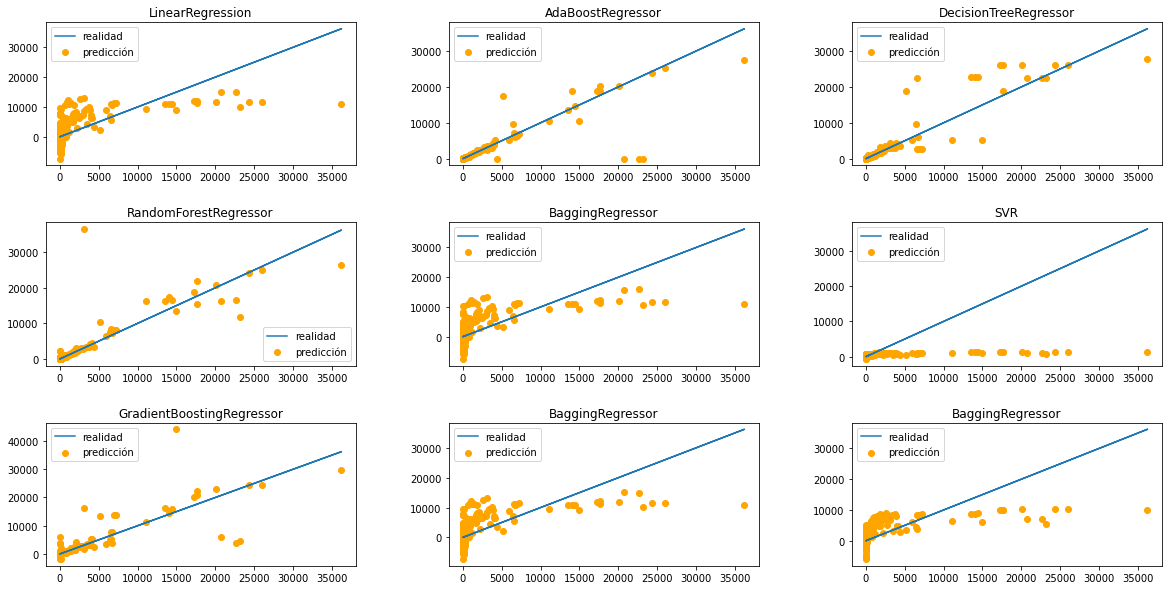

In [37]:
gp.varios_plot_regresion(lista_estimadores,x_train,y_train,x_test,y_test,hspace=0.4,figsize=(20,10),columnas=3)

Si los miramos gráficamente podemos ver que los mejor ajustados son el Random Forest,el AdaBoost, el Gradient Boosting y el Decision Tree que son los que mejores métricas de error absoluto y al cuadrado tienen, pero se quedan atrás todos ellos respecto a bondad de ajuste respecto a AdaBoostRegressor, el cual además tiene el menor mae con una desviación típica similar al resto y el mse es muy parecido a RandomForest, que es el que mejor lo hace con una desviación típica entre validaciones similar. Por tanto para el cluster 0 vamos a trabajar con el estimador:
$$\text{AdBoostRegressor(DecisionTreeRegressor())}$$

escogemos los datos para el cluster 0, los dividimos en train y test y luego los transformamos. Lo hacemos ahora de nuevo y en este orden para que los datos contenidos en el test sean realmente nuevos y el modelo no los haya visto.

In [38]:
df_tuning = df.select_dtypes(exclude="object").drop(["latitude","longitude"],axis=1)
df_cluster = df_tuning[df_tuning.clusters==0].reset_index(drop=True)

## SELECCIÓN DE VARIABLES PARA EL CLUSTER 0
### Modelo Cluster 0: variables mediante Correlación

In [39]:
corr_vars = [x for x in df_cluster if x not in ["Energy_production",
                                                "Energy_consumption",
                                                "CO2_emission","balance"]]

x_train,x_test,y_train,y_test = gp.data_transform(df_cluster,"eficiency",
                                                PowerTransformer(),
                                                skip_t=["energy_type"],
                                                skip_x=corr_vars)

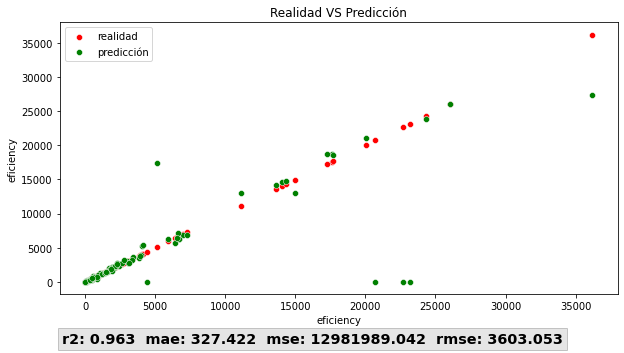

In [40]:
Predicting.cross_val_regression(lista_estimadores[1],x_train,y_train,x_test,y_test)

Vemos que los datos de AdaBoost se han mejorado pasando de un x con todas las variables a un x con las variables que mayor correlación tienen en r2.
En términos de mae, rmse y mse también hemos mejorado.

### Modelo Cluster 0: variables mediante Vif

In [41]:
vif_vars = [x for x in df_cluster if x not in var_vif_0]

x_train,x_test,y_train,y_test = gp.data_transform(df_cluster,"eficiency",
                                                PowerTransformer(),
                                                skip_t=["energy_type"],
                                                skip_x=vif_vars)

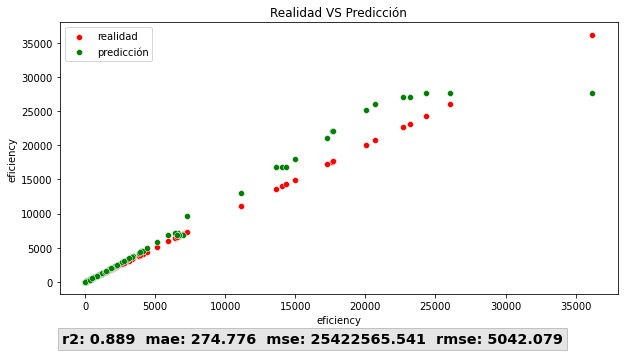

In [42]:
Predicting.cross_val_regression(lista_estimadores[1],x_train,y_train,x_test,y_test)

Respecto al Base Line se ha mejorado pero lo hace peor en R2 y rmse que las variables seleccionadas mediante correlación, aunque en mae lo hace mejor.

### Modelo Cluster 0: variables mediante RFECV

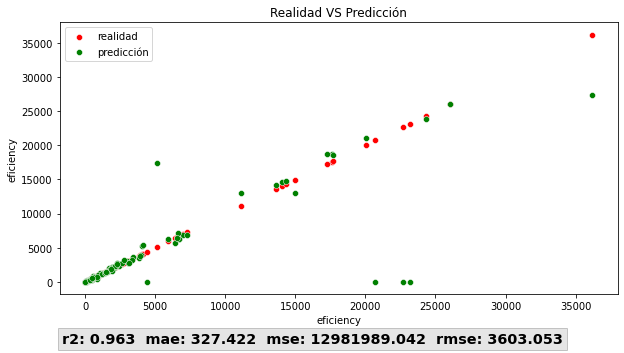

In [43]:
rfecv_vars = [x for x in df_cluster if x not in rfecv_vars_0]

x_train,x_test,y_train,y_test = gp.data_transform(df_cluster,"eficiency",
                                                PowerTransformer(),
                                                skip_t=["energy_type"],
                                                skip_x=rfecv_vars)
                                                
Predicting.cross_val_regression(lista_estimadores[1],x_train,y_train,x_test,y_test)

Nos sale el mismo resultado con las variables elegidas mediante rfecv que mediante correlación porque son las mismas variables a las que hemos llegado como conclusión:

In [44]:
rfecv_vars_0

['balance', 'Energy_production', 'Energy_consumption', 'CO2_emission']

In [45]:
var_corr_0

['Energy_production', 'Energy_consumption', 'CO2_emission', 'balance']

### Modelo Cluster 0: variables mediante OLS de Statsmodels
Para este cluster nos indicaba que no era neceario eliminar ninguna de las variables y por tanto sabemos, porque fue el baseline inicial, que no mejora a los otros modelos con las variables seleccionadas.

### CONCLUSIÓN PARA EL CLUSTER 0:
Se usará el estimador: 
$$\text{AdaBoostRegressor con base en DecisionTreeRegressor}$$ 
Las variables a usar serán las obtenidas mediante mayor correlación y rfecv, pues son las mismas:  
`["Energy_production","Energy_consumption","CO2_emission","balance"]`

In [46]:
corr_vars = [x for x in df_cluster if x not in var_corr_0]

x_train,x_test,y_train,y_test = gp.data_transform(df_cluster,"eficiency",
                                                PowerTransformer(),
                                                skip_t=["energy_type"],
                                                skip_x=corr_vars)
# Guardamos el modelo para el cluster 0:
reg_cluster0 = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(random_state=0))
reg_cluster0fit = reg_cluster0.fit(x_train,y_train)
gp.models_saver(reg_cluster0fit,"reg_cluster0")

Modelo guardado correctamente


## Base line para el cluster 1:

In [47]:
df_cluster = df_tuning[df_tuning.clusters==1].reset_index(drop=True)

x_train,x_test,y_train,y_test = gp.data_transform(df_cluster,"eficiency",
                                                PowerTransformer(),
                                                skip_t=["energy_type"],
                                                skip_x=["eficiency","clusters"])

In [48]:
gp.crossval_models(x_train,y_train,10,lista_estimadores,"r2")

In [49]:
gp.crossval_models(x_train,y_train,10,lista_estimadores,"neg_mean_absolute_error")

In [50]:
gp.crossval_models(x_train,y_train,10,lista_estimadores,"neg_mean_squared_error")

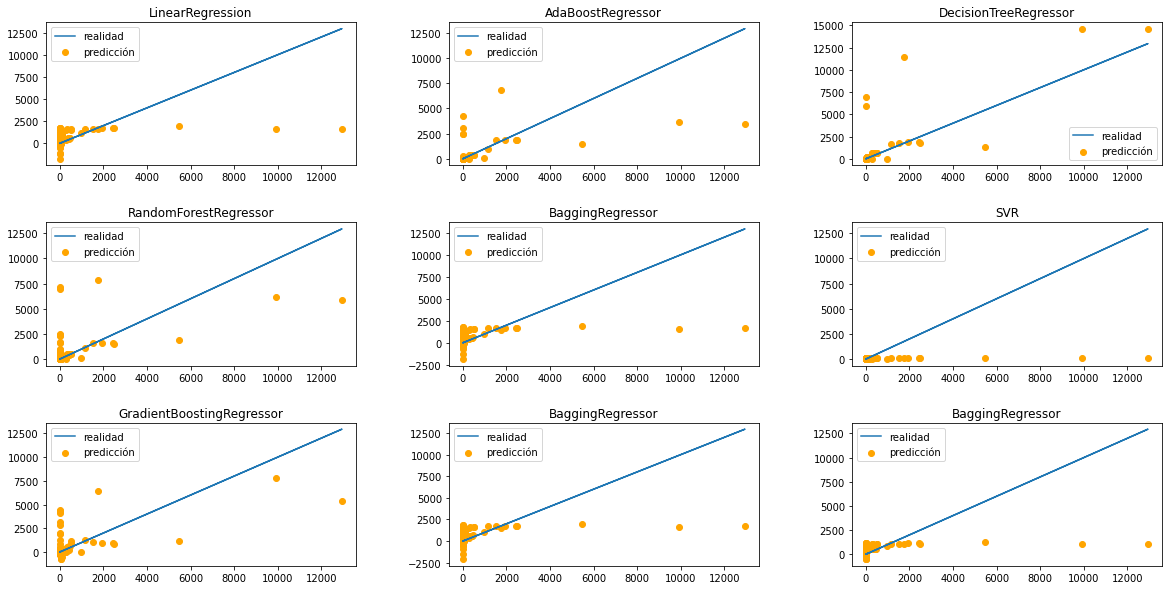

In [51]:
gp.varios_plot_regresion(lista_estimadores,x_train,y_train,x_test,y_test,
                                hspace=0.4,figsize=(20,10),columnas=3)

Para el cluster 1 todavía no podemos decidir sobre que algoritmo vamos a usar porque los datos son realmente malos.

# SELECCIÓN DE VARIABLES PARA EL CLUSTER 1
### Modelo Cluster 1: variables mediante Correlación 

Hemos revisado diferentes alternativas, entre ellas:
* usar powertransformer, que vuelve las variables más parecidas a una distribución Gaussiana, quitando los valores extremos, que no eran muchos.
* usar RobustScaler quitando igualmente los valores extremos.
* RobustScaler sin quitar los valores extremos  

Como RobustScaler scaler centra y escala los datos usando la mediana y el rango intercuartílico, y como en este dataset tenemos algunos datos extremos, hemos pensado que sería una buena opción para normalizar los datos ya que estos datos tan altos afectan negativamente a las medias y la varianza. Al final la tercera opción ha sido la que arroja unos resultados más normales. De esta manera, la opción de variables mediante correlación es mala de todas formas posibles, pues en este grupo todas las variables tienen poca correlación con la eficiencia ,y por tanto solo nos quedaron dos variables a usar. En las demás opciones tenemos estimadores que tienen resultados normales y otros que obtienen valores de r2 iguales a 1 y de 0 en las métricas de errores, por lo que no son estimadores a tener en cuenta.

In [52]:
df_cluster = df_tuning[df_tuning.clusters==1].reset_index(drop=True)
corr_vars = [x for x in df_cluster if x not in var_corr_1]

x_train,x_test,y_train,y_test = gp.data_transform(df_cluster,"eficiency",
                                                RobustScaler(),
                                                skip_t=["energy_type"],
                                                skip_x=corr_vars)

***************LinearRegression()***************


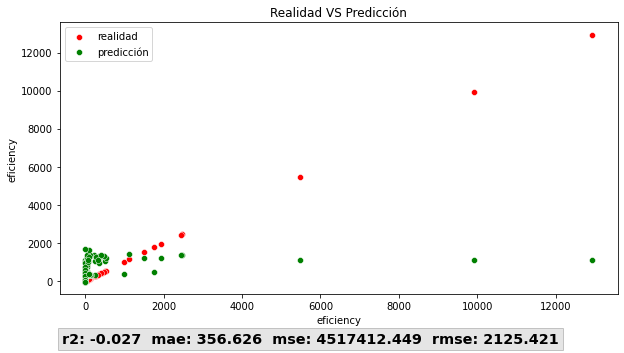

***************AdaBoostRegressor(base_estimator=DecisionTreeRegressor(random_state=0),
                  learning_rate=0.1, random_state=0)***************


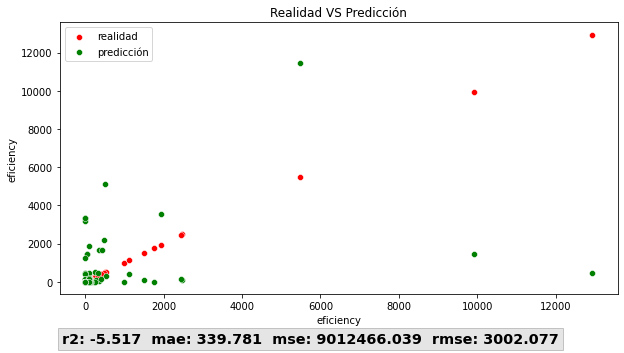

***************DecisionTreeRegressor(random_state=0)***************


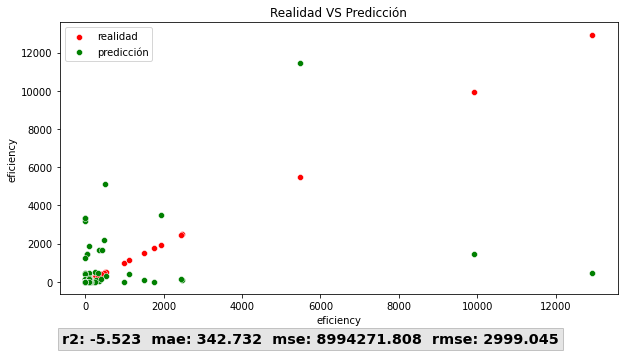

***************RandomForestRegressor(random_state=0)***************


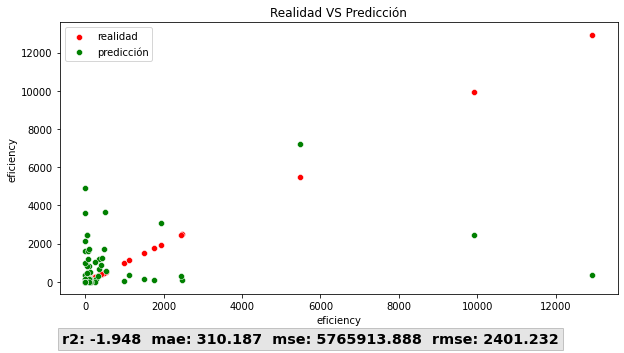

***************BaggingRegressor(base_estimator=Lasso(random_state=0))***************


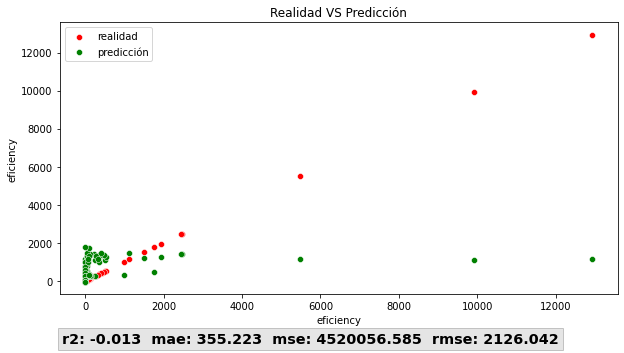

***************SVR(kernel='linear')***************


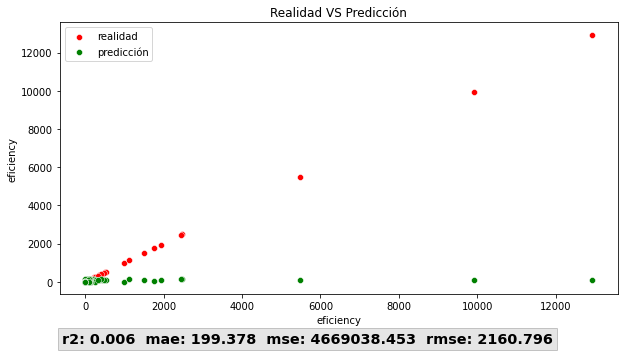

***************GradientBoostingRegressor(random_state=0)***************


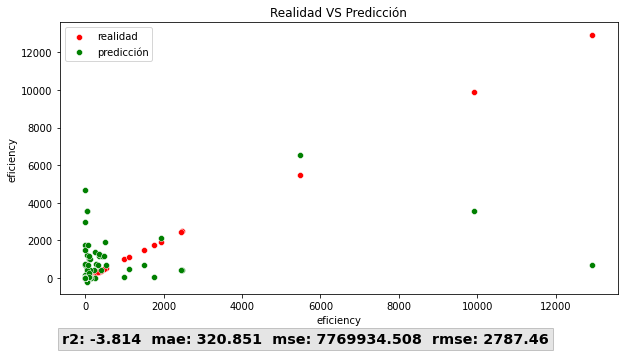

***************BaggingRegressor(base_estimator=Ridge(random_state=0))***************


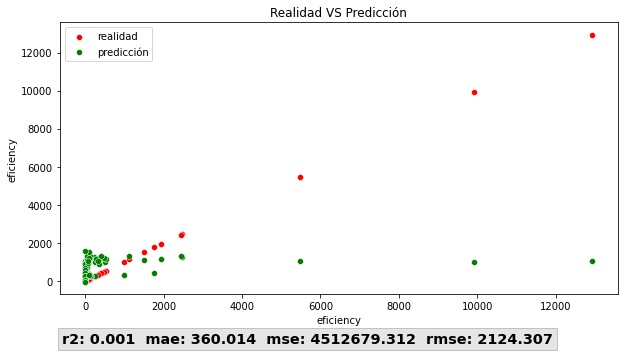

***************BaggingRegressor(base_estimator=ElasticNet(random_state=0))***************


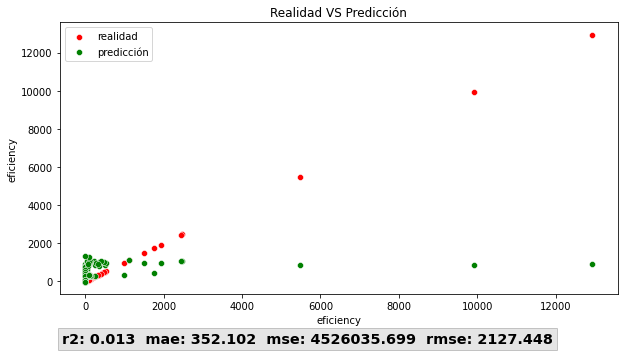

In [53]:
for estimador in lista_estimadores:
    print(f"***************{str(estimador)}***************")
    Predicting.cross_val_regression(estimador,x_train,y_train,x_test,y_test)

### Modelo Cluster 1: variables mediante Vif

***************LinearRegression()***************


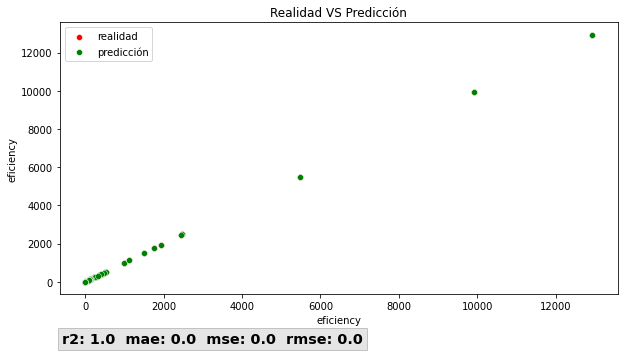

***************AdaBoostRegressor(base_estimator=DecisionTreeRegressor(random_state=0),
                  learning_rate=0.1, random_state=0)***************


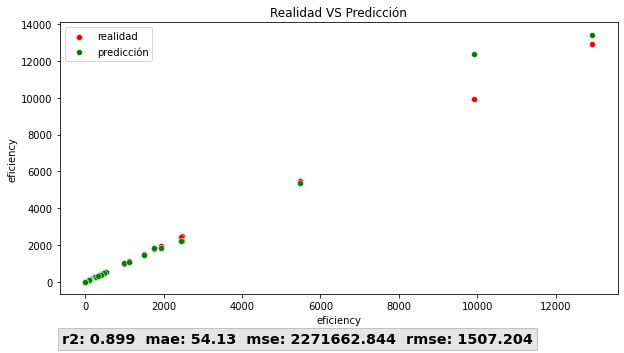

***************DecisionTreeRegressor(random_state=0)***************


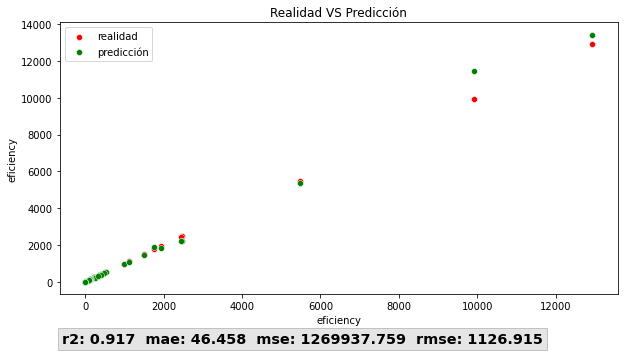

***************RandomForestRegressor(random_state=0)***************


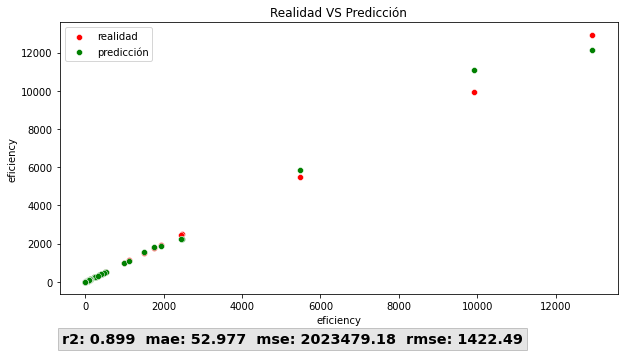

***************BaggingRegressor(base_estimator=Lasso(random_state=0))***************


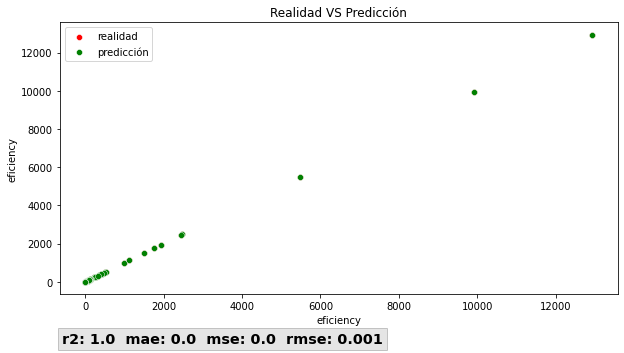

***************SVR(kernel='linear')***************


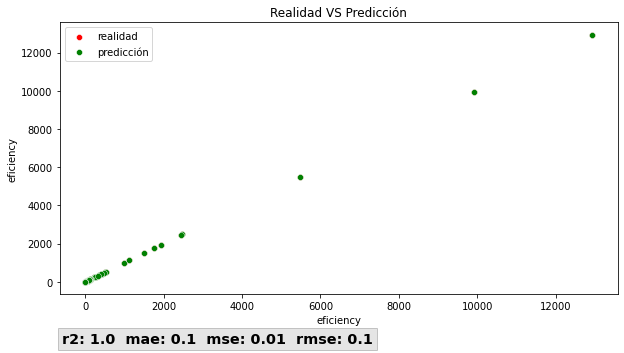

***************GradientBoostingRegressor(random_state=0)***************


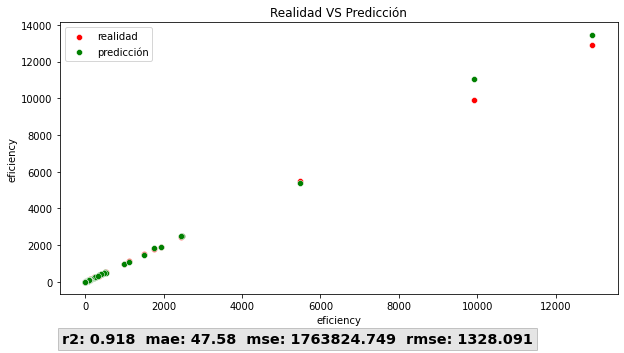

***************BaggingRegressor(base_estimator=Ridge(random_state=0))***************


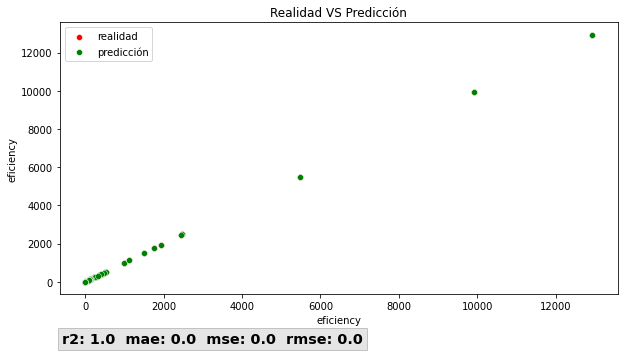

***************BaggingRegressor(base_estimator=ElasticNet(random_state=0))***************


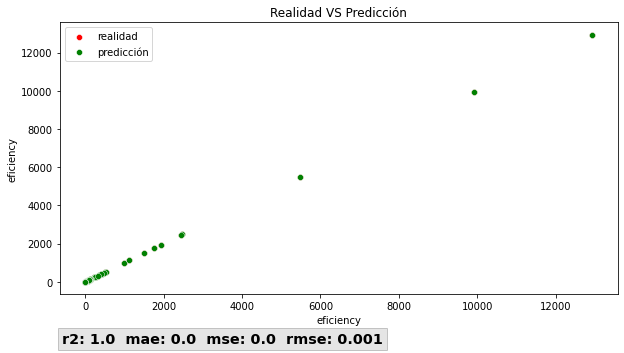

In [54]:
vif_vars = [x for x in df_cluster if x not in var_vif_1]

x_train,x_test,y_train,y_test = gp.data_transform(df_cluster,"eficiency",
                                                RobustScaler(),
                                                skip_t=["energy_type"],
                                                skip_x=vif_vars)
for estimador in lista_estimadores:
    print(f"***************{str(estimador)}***************")
    Predicting.cross_val_regression(estimador,x_train,y_train,x_test,y_test)

### Modelo Cluster 1: variables mediante OLS de Statsmodels

***************LinearRegression()***************


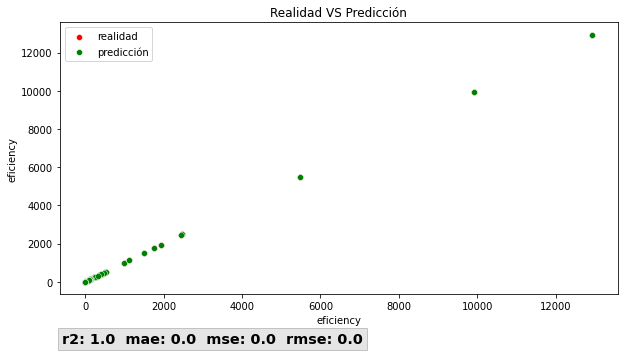

***************AdaBoostRegressor(base_estimator=DecisionTreeRegressor(random_state=0),
                  learning_rate=0.1, random_state=0)***************


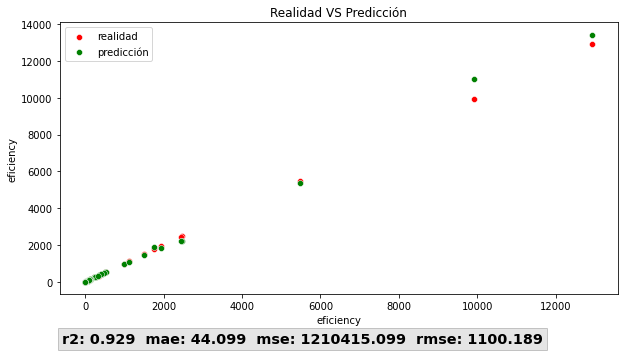

***************DecisionTreeRegressor(random_state=0)***************


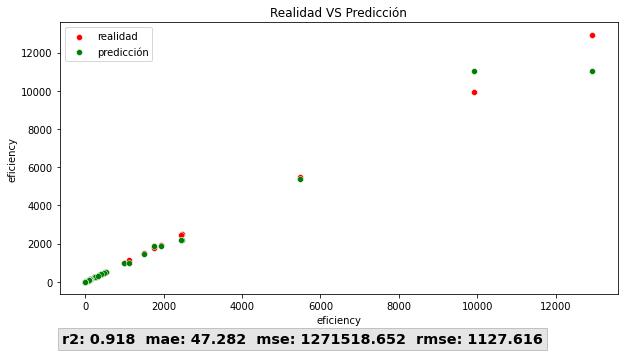

***************RandomForestRegressor(random_state=0)***************


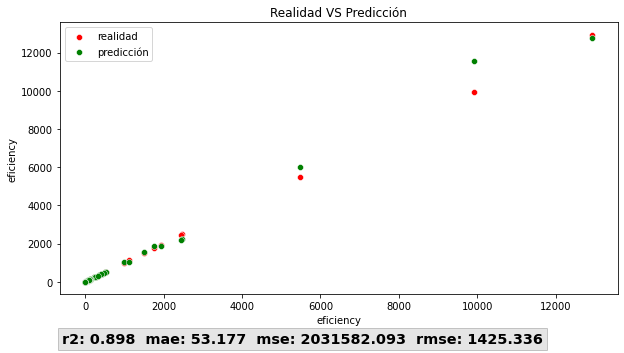

***************BaggingRegressor(base_estimator=Lasso(random_state=0))***************


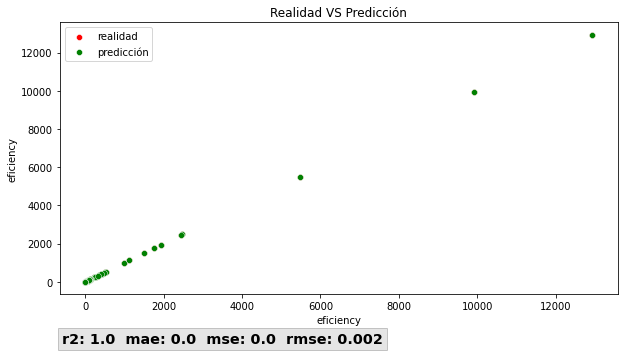

***************SVR(kernel='linear')***************


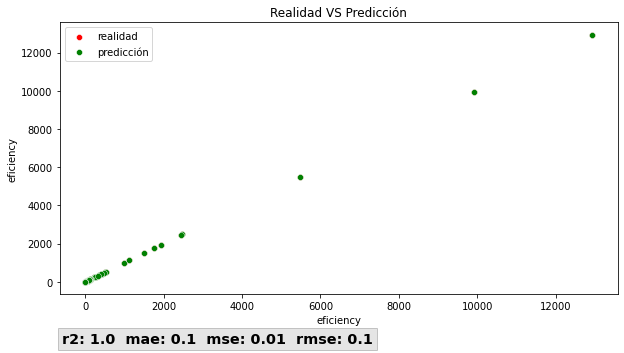

***************GradientBoostingRegressor(random_state=0)***************


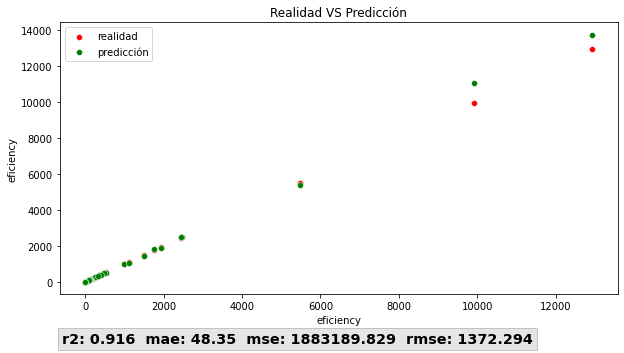

***************BaggingRegressor(base_estimator=Ridge(random_state=0))***************


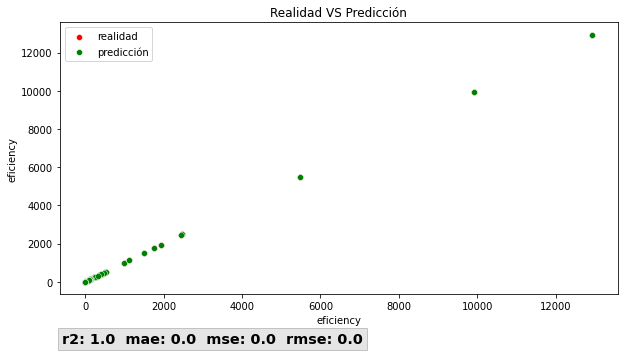

***************BaggingRegressor(base_estimator=ElasticNet(random_state=0))***************


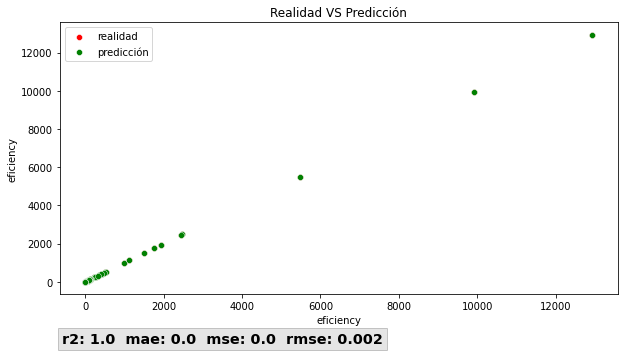

In [55]:
ols_vars = ["use_intensity_pc"]

x_train,x_test,y_train,y_test = gp.data_transform(df_cluster,"eficiency",
                                                RobustScaler(),
                                                skip_t=["energy_type"],
                                                skip_x=ols_vars)
for estimador in lista_estimadores:
    print(f"***************{str(estimador)}***************")
    Predicting.cross_val_regression(estimador,x_train,y_train,x_test,y_test)

### Modelo Cluster 1: variables mediante RFECV

***************LinearRegression()***************


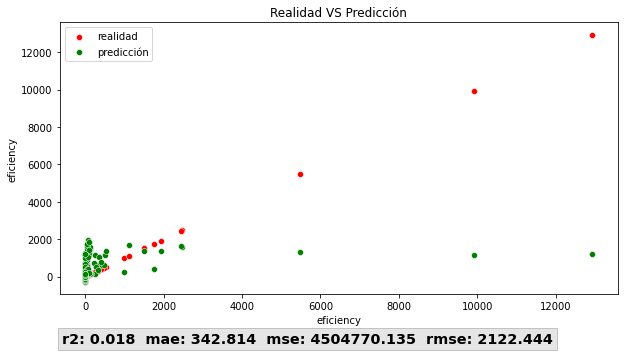

***************AdaBoostRegressor(base_estimator=DecisionTreeRegressor(random_state=0),
                  learning_rate=0.1, random_state=0)***************


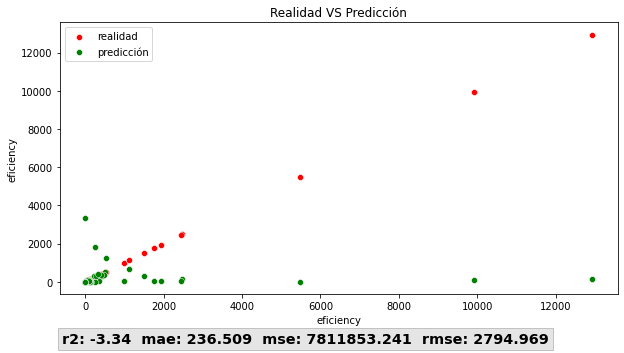

***************DecisionTreeRegressor(random_state=0)***************


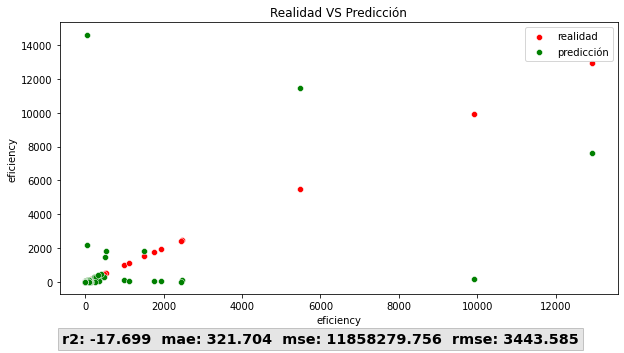

***************RandomForestRegressor(random_state=0)***************


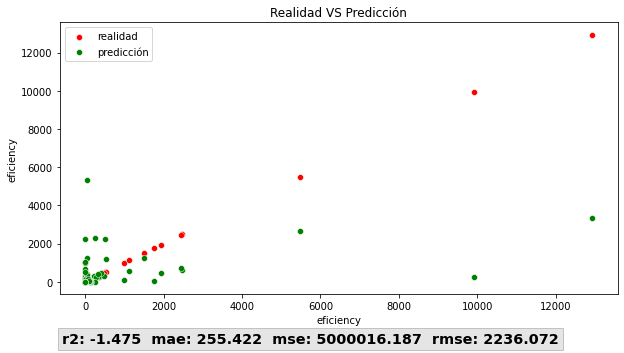

***************BaggingRegressor(base_estimator=Lasso(random_state=0))***************


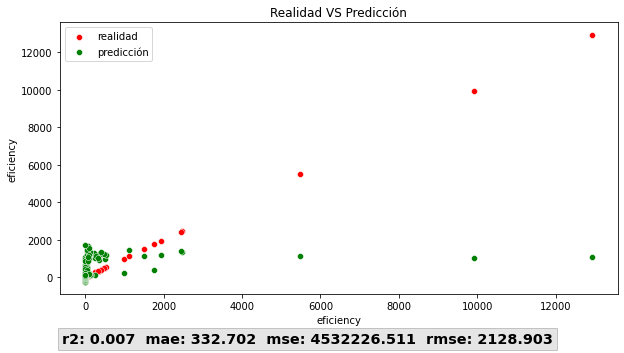

***************SVR(kernel='linear')***************


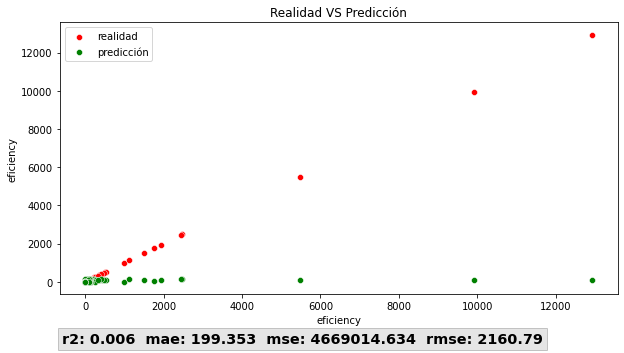

***************GradientBoostingRegressor(random_state=0)***************


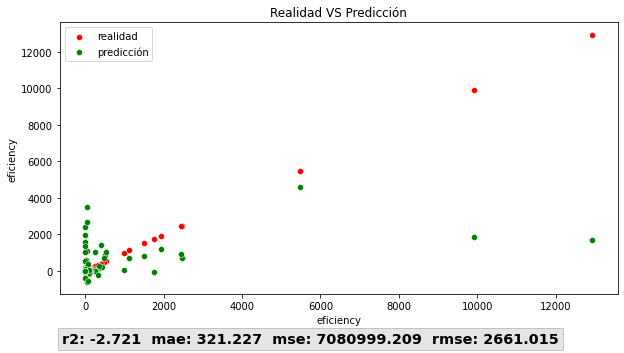

***************BaggingRegressor(base_estimator=Ridge(random_state=0))***************


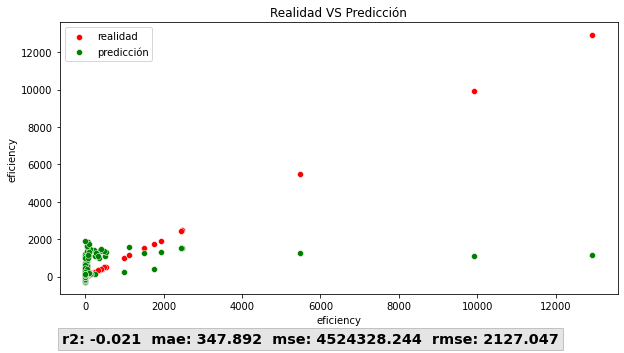

***************BaggingRegressor(base_estimator=ElasticNet(random_state=0))***************


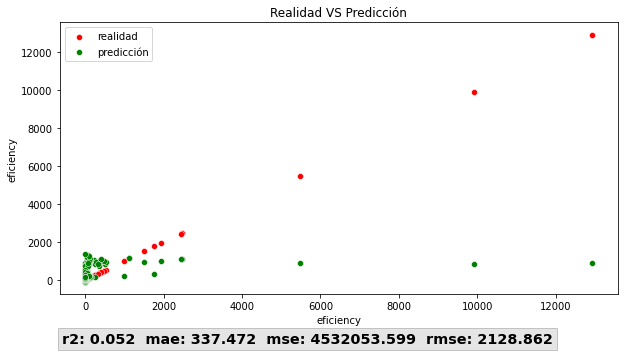

In [56]:
rfecv_vars = [x for x in df_cluster if x not in rfecv_vars_1]

x_train,x_test,y_train,y_test = gp.data_transform(df_cluster,"eficiency",
                                                RobustScaler(),
                                                skip_t=["energy_type"],
                                                skip_x=rfecv_vars)
for estimador in lista_estimadores:
    print(f"***************{str(estimador)}***************")
    Predicting.cross_val_regression(estimador,x_train,y_train,x_test,y_test)

En este cluster el modelo de dos variables seleccionadas mediante correlación ha sido descartado directamente puesto que las métricas obtenidas eran malas. El modelo no explicaba la variabilidad de los datos del grupo y no generalizaba bien. En el resto de modelos se ha mantenido una constante, y es que en todos ellos los modelos que mejor lo han hecho han sido:

* AdaBoost-DecisionTree
* DecisionTree
* RandomForest
* GradientBoostingRegressor

De todos ellos los que mejores métricas han obtenido han sido DecisionTree con el modelo de vif, AdaBoost con el modelo de ols y, de nuevo, DecisionTree con el modelo de RFECV. De estos tres, los datos han sido:  

|estimador|R2|Mae|Rmse|n_variables|
|---------|--|---|----|-----------|
|DecisionTree-vif|0.917|46.46|1126.91|11|
|ADA-Ols|0.929|44.01|1100.19|11|
|<mark>DecisionTree-rfecv</mark>|0.925|44.73|1110.34|4|

Por tanto, de los tres modelos elegimos:
$$\text{DecisionTree-rfecv}$$
Debido a que muestra datos muy cercanos y en algunos casos mejores a los otros dos con una complejidad reducida de solo cuatro variables, estas son:  
`['CO2_emission', 'co2_pc', 'Energy_consumption', 'Energy_intensity_by_GDP']`

In [57]:
rfecv_vars = [x for x in df_cluster if x not in rfecv_vars_1]

x_train,x_test,y_train,y_test = gp.data_transform(df_cluster,"eficiency",
                                                RobustScaler(),
                                                skip_t=["energy_type"],
                                                skip_x=rfecv_vars)

# Guardamos el modelo para el cluster 1:
reg_cluster1 = DecisionTreeRegressor(random_state=0)
reg_cluster1fit = reg_cluster1.fit(x_train,y_train)
gp.models_saver(reg_cluster1fit,"reg_cluster1")

Modelo guardado correctamente


Para el cluster 2:

In [58]:
# Dividimos el dataframe:
y = df[df.clusters==2].eficiency
X = df2[[x for x in df2.columns if x not in ["eficiency","clusters"]]]

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [59]:
gp.crossval_models(x_train,y_train,10,lista_estimadores,"r2")

In [60]:
gp.crossval_models(x_train,y_train,10,lista_estimadores,"neg_mean_absolute_error")

In [61]:
gp.crossval_models(x_train,y_train,10,lista_estimadores,"neg_mean_squared_error")

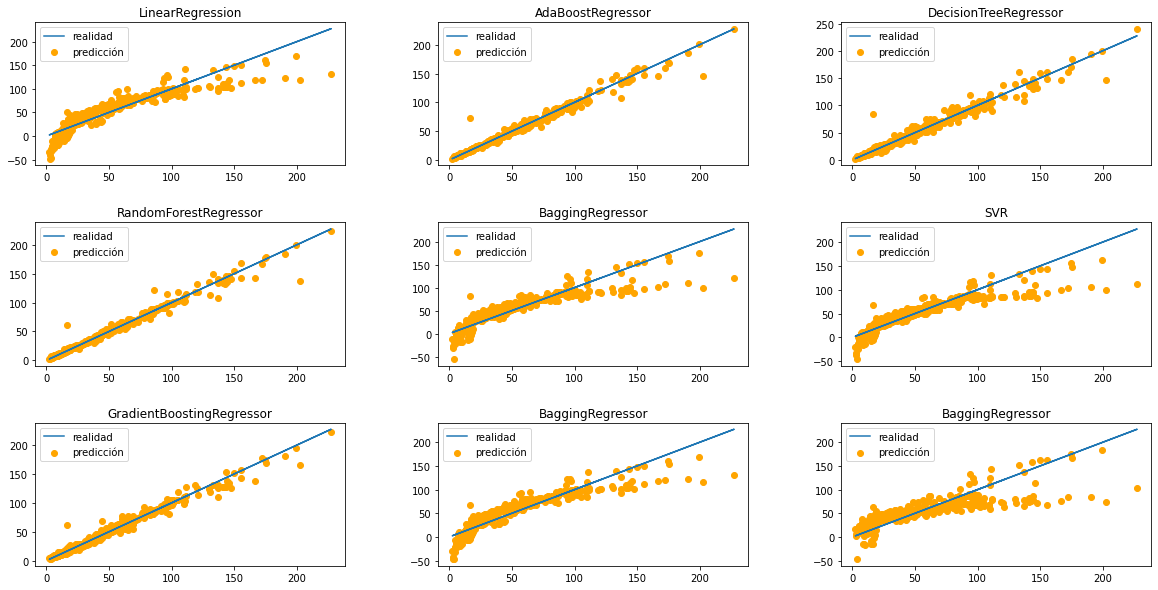

In [62]:
gp.varios_plot_regresion(lista_estimadores,x_train,y_train,x_test,y_test,
                                hspace=0.4,figsize=(20,10),columnas=3)

Para el cluster 2 el mejor estimador ha sido AdaBoost con Decision Tree al tener el mejor dato de mean squared error, mean absolute error y estar prácticamente al mismo nivel de r2 que el mejor de todos que ha sido GradientBoosting.

# SELECCIÓN DE VARIABLES PARA EL CLUSTER 2
### Modelo Cluster 2: variables mediante Correlación 

In [63]:
df_cluster = df_tuning[df_tuning.clusters==2].reset_index(drop=True)

***************LinearRegression()***************


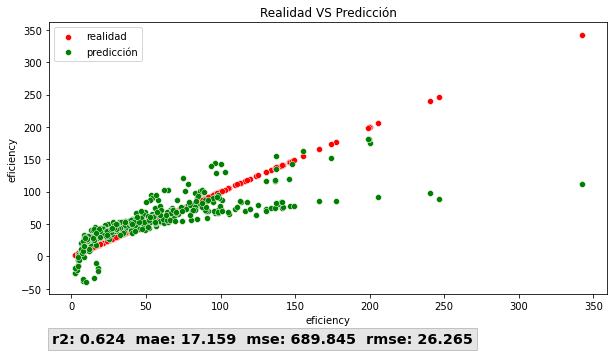

***************AdaBoostRegressor(base_estimator=DecisionTreeRegressor(random_state=0),
                  learning_rate=0.1, random_state=0)***************


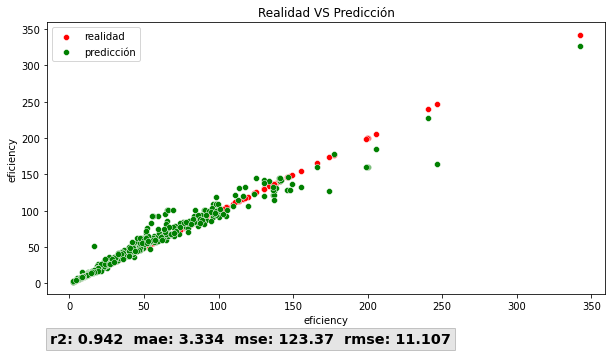

***************DecisionTreeRegressor(random_state=0)***************


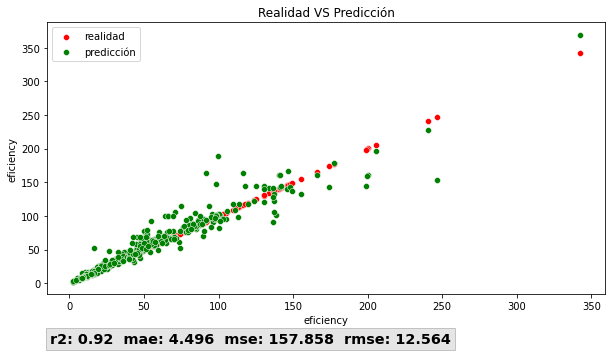

***************RandomForestRegressor(random_state=0)***************


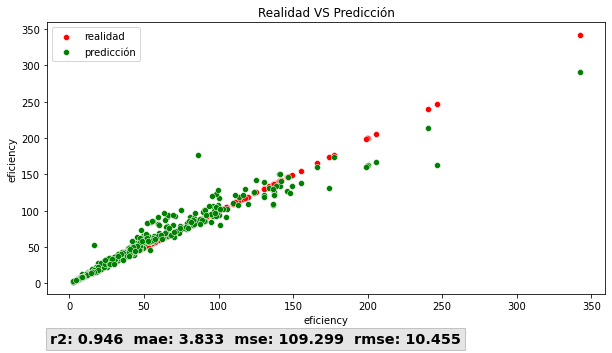

***************BaggingRegressor(base_estimator=Lasso(random_state=0))***************


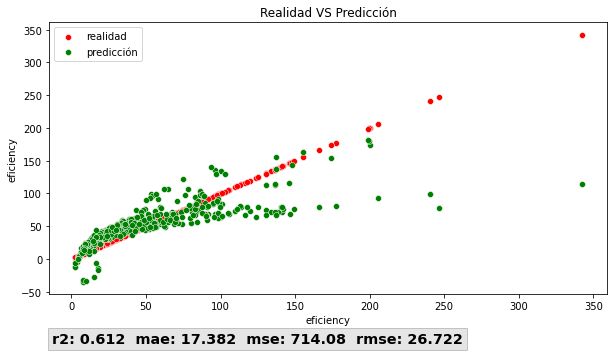

***************SVR(kernel='linear')***************


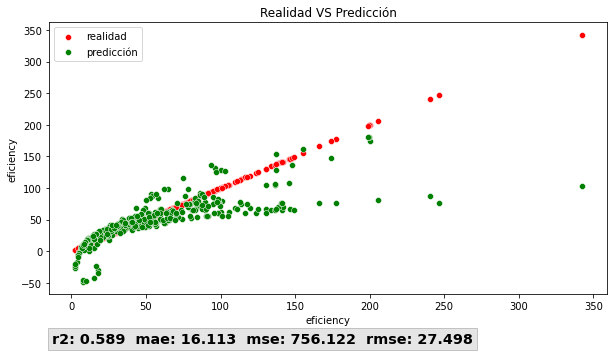

***************GradientBoostingRegressor(random_state=0)***************


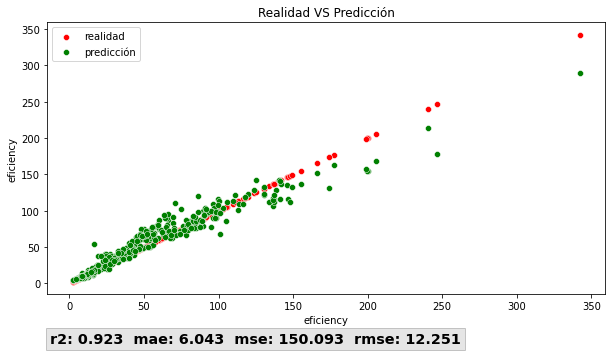

***************BaggingRegressor(base_estimator=Ridge(random_state=0))***************


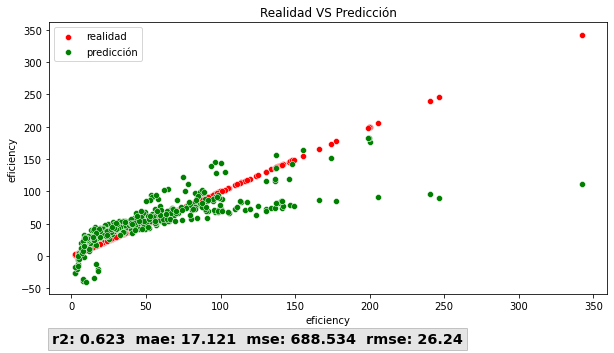

***************BaggingRegressor(base_estimator=ElasticNet(random_state=0))***************


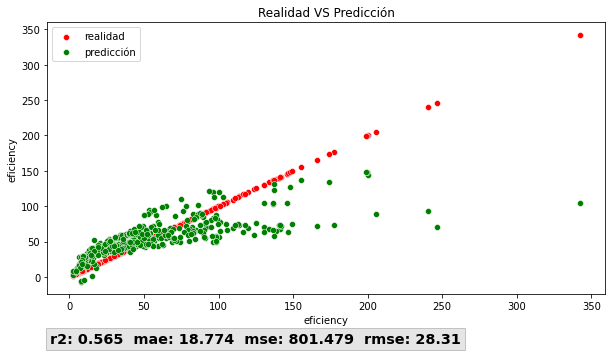

In [64]:
corr_vars = [x for x in df_cluster if x not in var_corr_2]

x_train,x_test,y_train,y_test = gp.data_transform(df_cluster,"eficiency",
                                                PowerTransformer(),
                                                skip_t=["energy_type"],
                                                skip_x=corr_vars)
for estimador in lista_estimadores:
    print(f"***************{str(estimador)}***************")
    Predicting.cross_val_regression(estimador,x_train,y_train,x_test,y_test)

### Modelo Cluster 2: variables mediante Vif

***************LinearRegression()***************


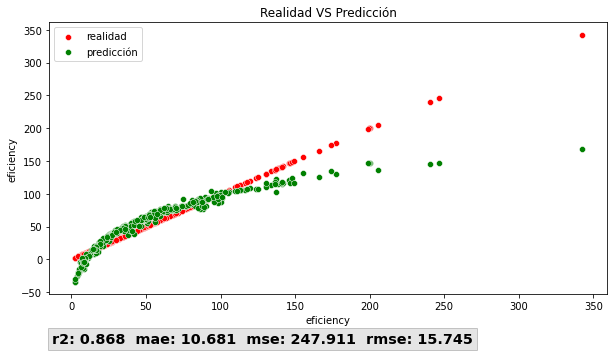

***************AdaBoostRegressor(base_estimator=DecisionTreeRegressor(random_state=0),
                  learning_rate=0.1, random_state=0)***************


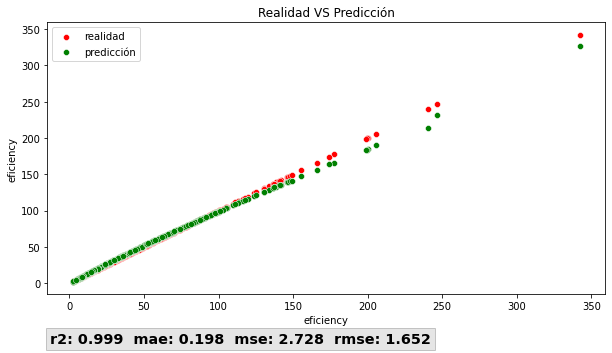

***************DecisionTreeRegressor(random_state=0)***************


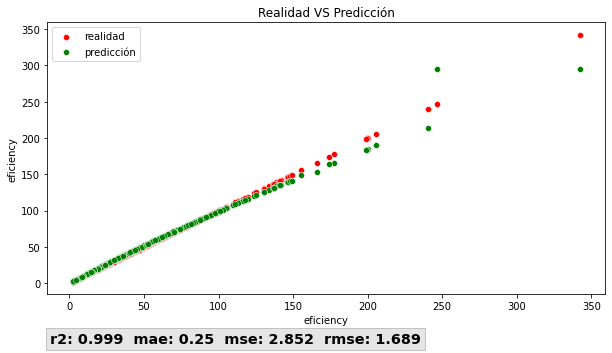

***************RandomForestRegressor(random_state=0)***************


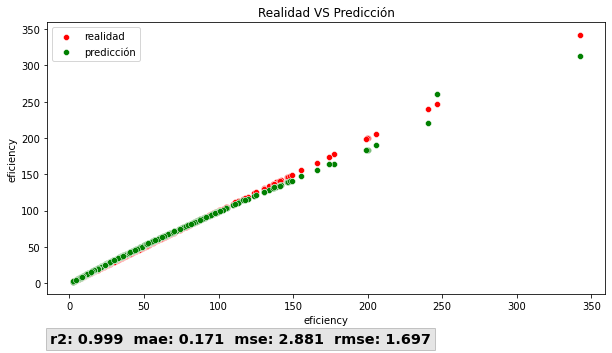

***************BaggingRegressor(base_estimator=Lasso(random_state=0))***************


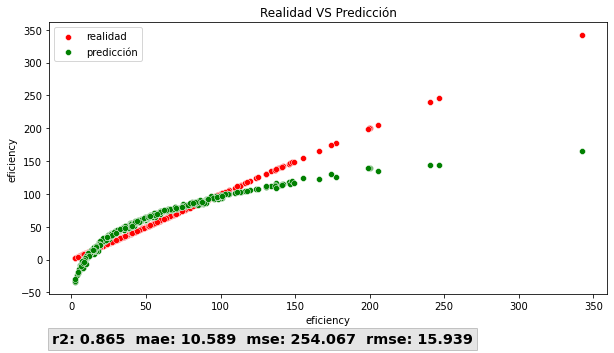

***************SVR(kernel='linear')***************


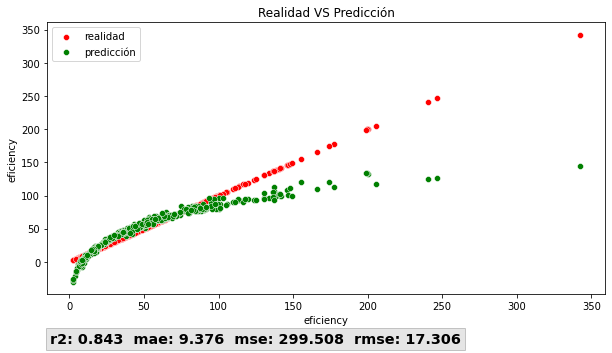

***************GradientBoostingRegressor(random_state=0)***************


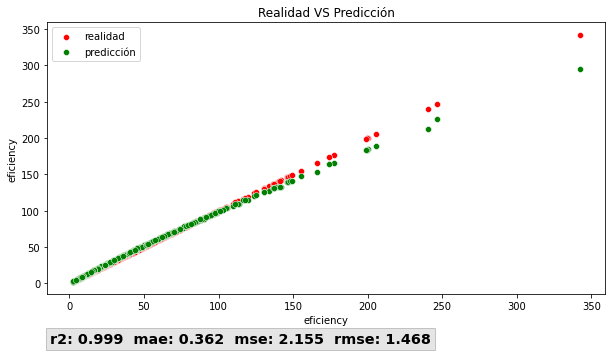

***************BaggingRegressor(base_estimator=Ridge(random_state=0))***************


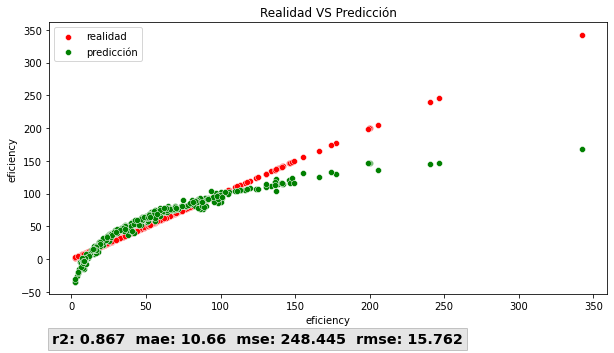

***************BaggingRegressor(base_estimator=ElasticNet(random_state=0))***************


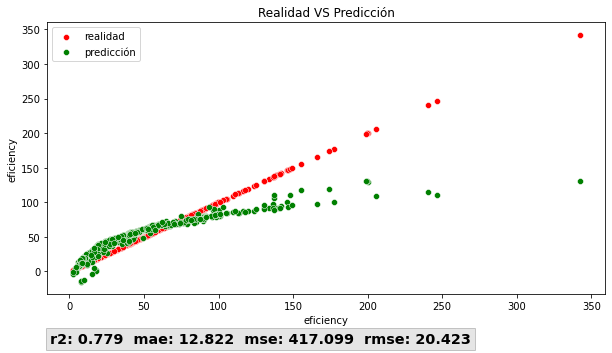

In [65]:
vif_vars = [x for x in df_cluster if x not in var_vif_2]

x_train,x_test,y_train,y_test = gp.data_transform(df_cluster,"eficiency",
                                                PowerTransformer(),
                                                skip_t=["energy_type"],
                                                skip_x=vif_vars)
for estimador in lista_estimadores:
    print(f"***************{str(estimador)}***************")
    Predicting.cross_val_regression(estimador,x_train,y_train,x_test,y_test)

### Modelo Cluster 2: variables mediante Rfecv

***************LinearRegression()***************


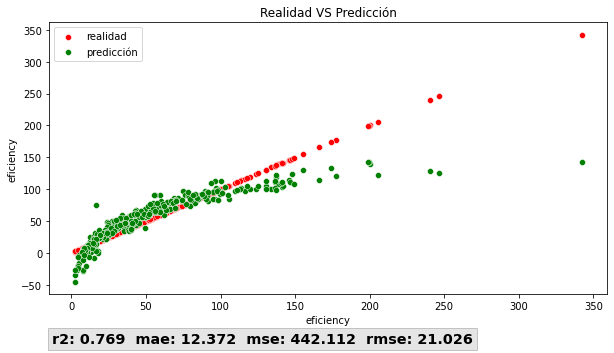

***************AdaBoostRegressor(base_estimator=DecisionTreeRegressor(random_state=0),
                  learning_rate=0.1, random_state=0)***************


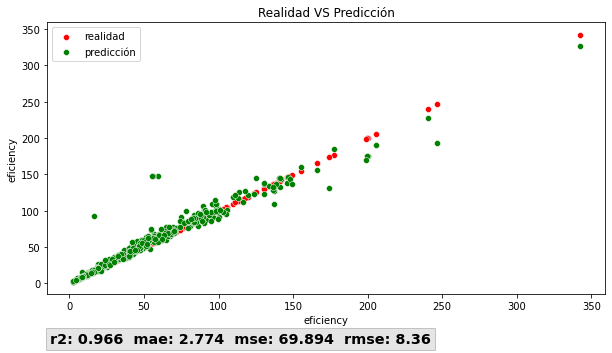

***************DecisionTreeRegressor(random_state=0)***************


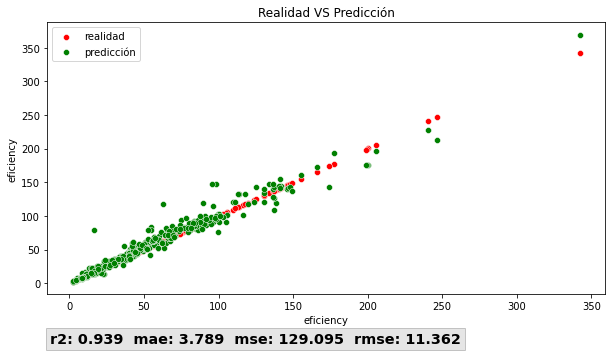

***************RandomForestRegressor(random_state=0)***************


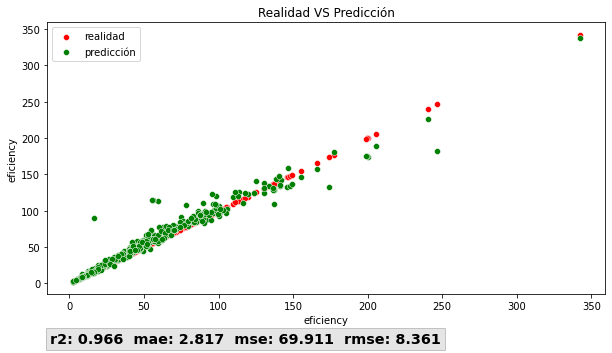

***************BaggingRegressor(base_estimator=Lasso(random_state=0))***************


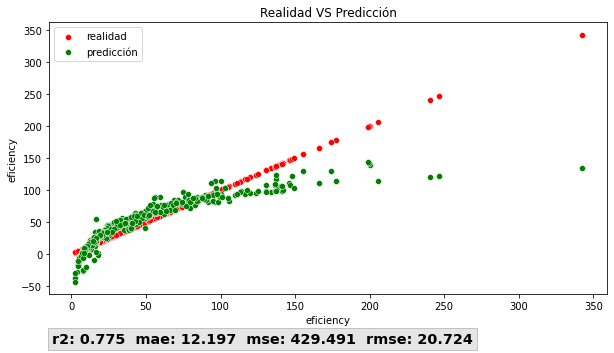

***************SVR(kernel='linear')***************


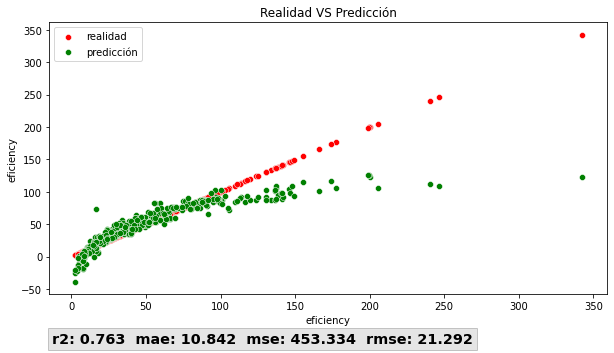

***************GradientBoostingRegressor(random_state=0)***************


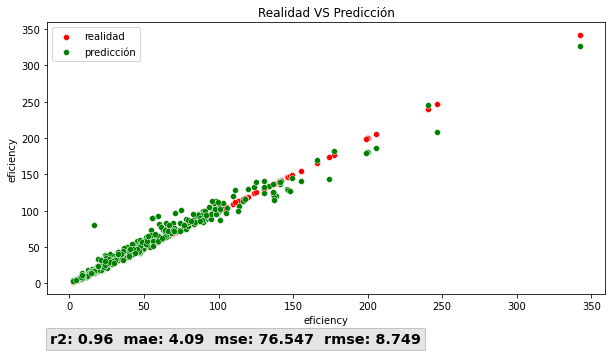

***************BaggingRegressor(base_estimator=Ridge(random_state=0))***************


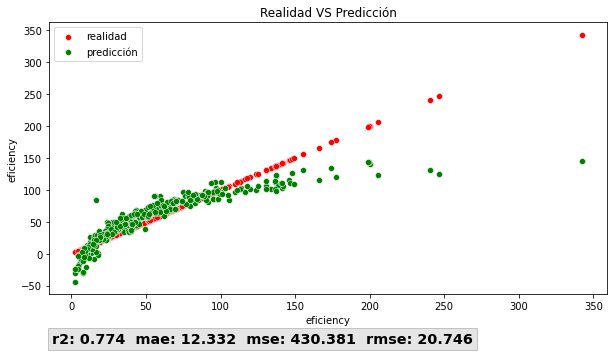

***************BaggingRegressor(base_estimator=ElasticNet(random_state=0))***************


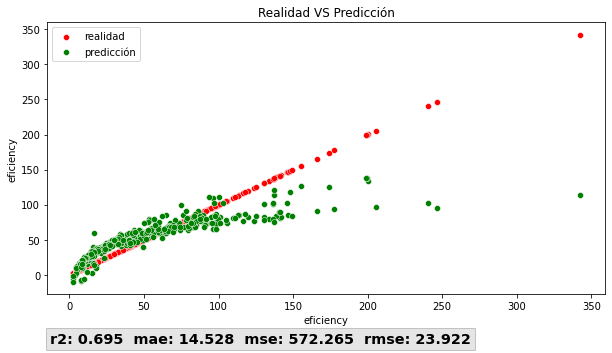

In [66]:
rfecv_vars = [x for x in df_cluster if x not in rfecv_vars_2]

x_train,x_test,y_train,y_test = gp.data_transform(df_cluster,"eficiency",
                                                PowerTransformer(),
                                                skip_t=["energy_type"],
                                                skip_x=rfecv_vars)
for estimador in lista_estimadores:
    print(f"***************{str(estimador)}***************")
    Predicting.cross_val_regression(estimador,x_train,y_train,x_test,y_test)

### Modelo Cluster 2: variables mediante OLS

Ya los probamos en el base line para el cluster 2, y puesto que ols nos recomienda no eliminar ninguna de las variables, y dado que no obtenía mejor r2 que los otros modelos, además de que la complejidad del modelo es máxima, no será un modelo elegible.  
Por otra parte, para cada modelo las mejores métricas han sido:

|estimador|R2|Mae|Rmse|n_variables|
|---------|--|---|----|-----------|
|<mark>RandomForest-Correlación</mark>|0.946|3.833|10.455|5|
|RandomForest-Vif|0.999|0.171|1.697|8|
|RandomForest-Rfecv|0.966|2.817|8.361|6|

de los cuales hemos elegido:
$$\text{RandomForest con las variables de correlación}$$
ya que tiene la menor complejidad, con 5 variables, y obtiene métricas tan buenas como el modelo de 6 variables mediante rfecv y similares a la selección mediante vif, que es posible que sea un modelo con mucha varianza y por tanto no generalizable.  
La estimación del modelo mediante el base line en el cual nos indicaba a AdaBoost no iba desencaminada, puesto que ADA ha sido uno de los mejores y estaba basado en DecisionTrees que al final es el algoritmo que hemos elegido pero mediante Bagging en vez de Boosting.

In [67]:
corr_vars = [x for x in df_cluster if x not in var_corr_2]

x_train,x_test,y_train,y_test = gp.data_transform(df_cluster,"eficiency",
                                                PowerTransformer(),
                                                skip_t=["energy_type"],
                                                skip_x=corr_vars)

# Guardamos el modelo para el cluster 2:
reg_cluster2 = RandomForestRegressor(random_state=0)
reg_cluster2fit = reg_cluster2.fit(x_train,y_train)
gp.models_saver(reg_cluster2fit,"reg_cluster2")

Modelo guardado correctamente


Para el cluster 3:

In [68]:
# Dividimos el dataframe:
y = df[df.clusters==3].eficiency
X = df3[[x for x in df3.columns if x not in ["eficiency","clusters"]]]

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [69]:
gp.crossval_models(x_train,y_train,10,lista_estimadores,"r2")

In [70]:
gp.crossval_models(x_train,y_train,10,lista_estimadores,"neg_mean_absolute_error")

In [71]:
gp.crossval_models(x_train,y_train,10,lista_estimadores,"neg_mean_squared_error")

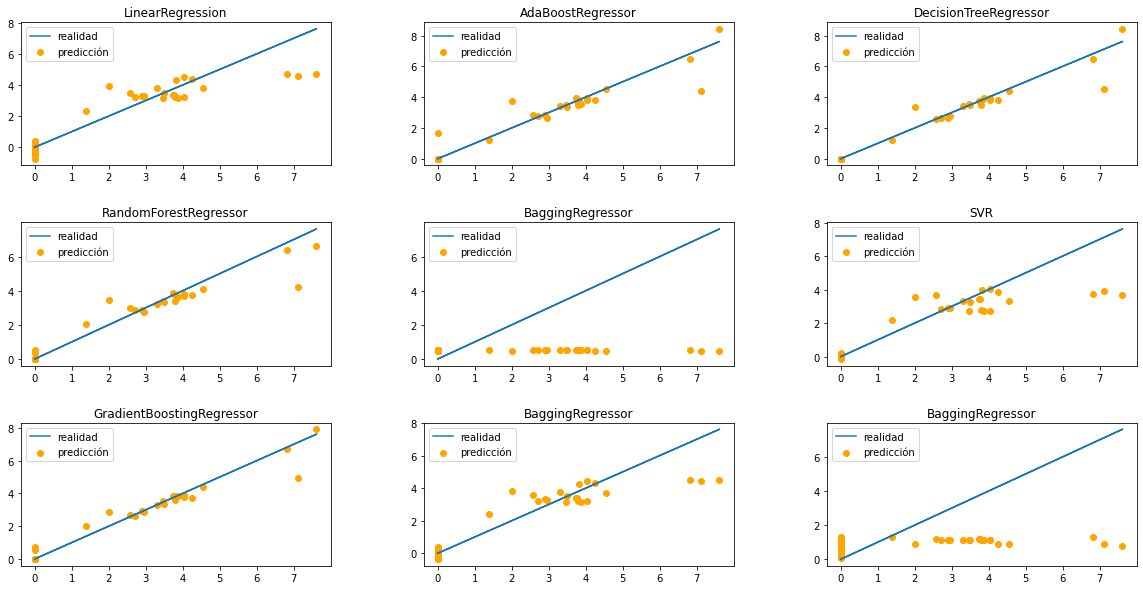

In [72]:
gp.varios_plot_regresion(lista_estimadores,x_train,y_train,x_test,y_test,
                                hspace=0.4,figsize=(20,10),columnas=3)

Para el cluster 3, claramente el mejor estimador es GradientBoostingRegressor usando todas las variables.

# SELECCIÓN DE VARIABLES PARA EL CLUSTER 3
### Modelo Cluster 3: variables mediante Correlación 

In [73]:
df_cluster = df_tuning[df_tuning.clusters==3].reset_index(drop=True)
corr_vars = [x for x in df_cluster if x not in var_corr_3]

x_train,x_test,y_train,y_test = gp.data_transform(df_cluster,"eficiency",
                                                PowerTransformer(),
                                                skip_t=["energy_type"],
                                                skip_x=corr_vars)

***************LinearRegression()***************


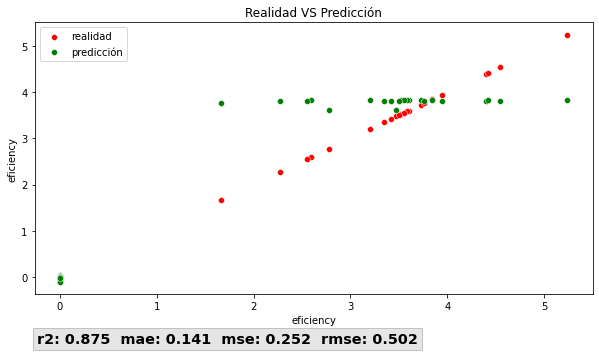

***************AdaBoostRegressor(base_estimator=DecisionTreeRegressor(random_state=0),
                  learning_rate=0.1, random_state=0)***************


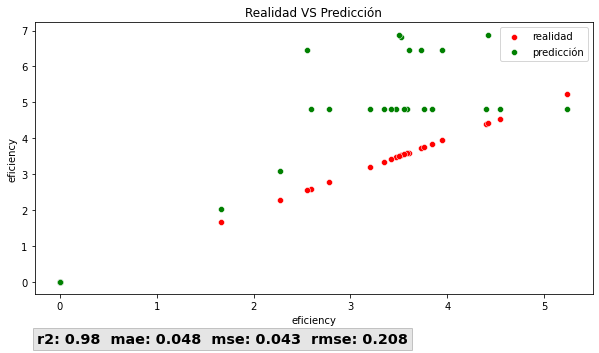

***************DecisionTreeRegressor(random_state=0)***************


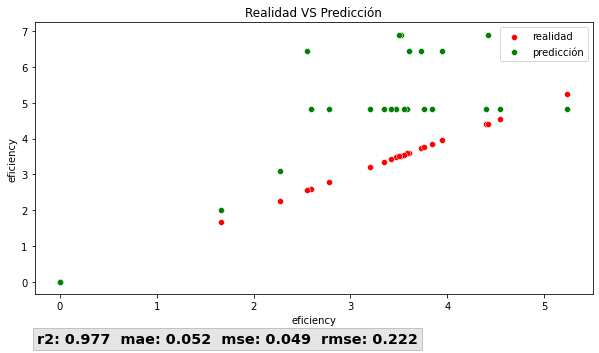

***************RandomForestRegressor(random_state=0)***************


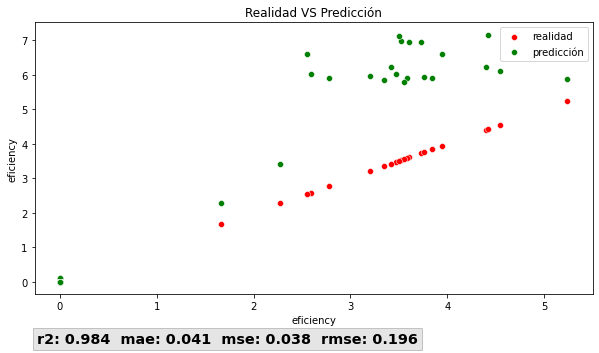

***************BaggingRegressor(base_estimator=Lasso(random_state=0))***************


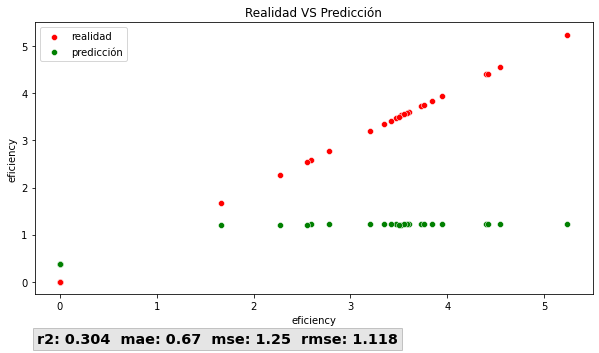

***************SVR(kernel='linear')***************


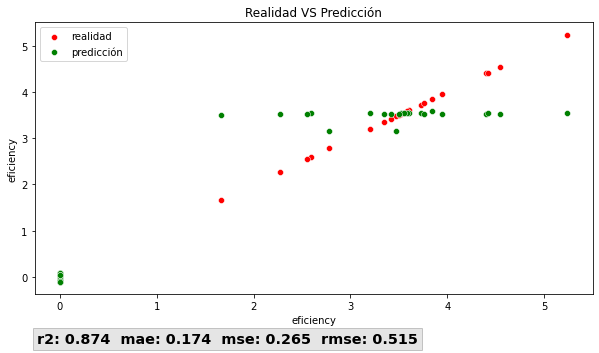

***************GradientBoostingRegressor(random_state=0)***************


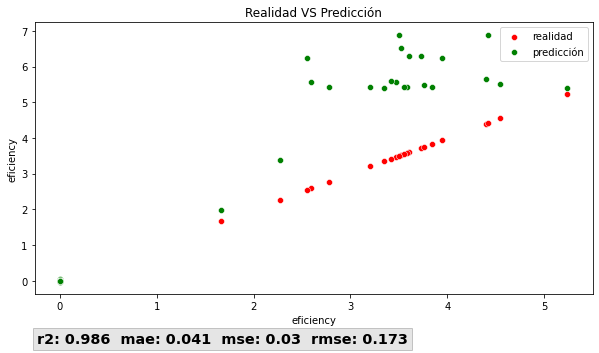

***************BaggingRegressor(base_estimator=Ridge(random_state=0))***************


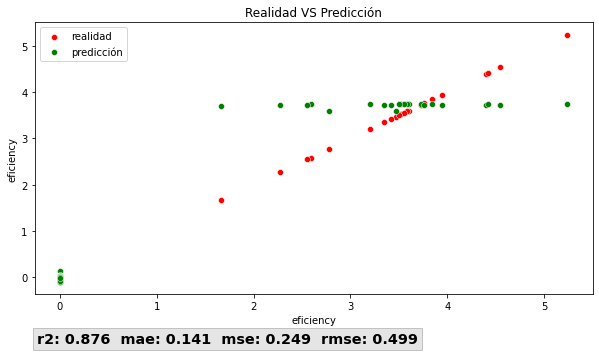

***************BaggingRegressor(base_estimator=ElasticNet(random_state=0))***************


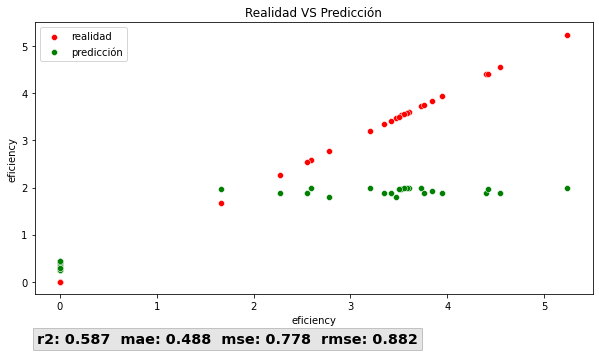

In [74]:
for estimador in lista_estimadores:
    print(f"***************{str(estimador)}***************")
    Predicting.cross_val_regression(estimador,x_train,y_train,x_test,y_test)

### Modelo Cluster 3: variables mediante Vif

***************LinearRegression()***************


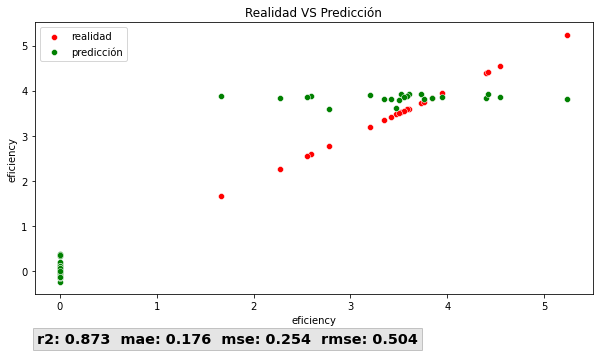

***************AdaBoostRegressor(base_estimator=DecisionTreeRegressor(random_state=0),
                  learning_rate=0.1, random_state=0)***************


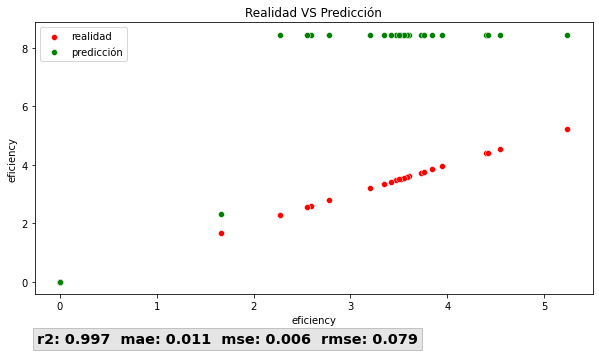

***************DecisionTreeRegressor(random_state=0)***************


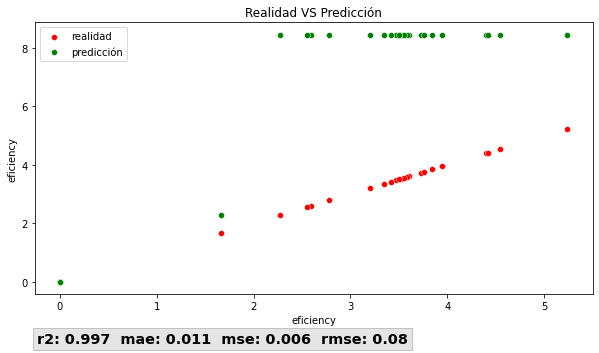

***************RandomForestRegressor(random_state=0)***************


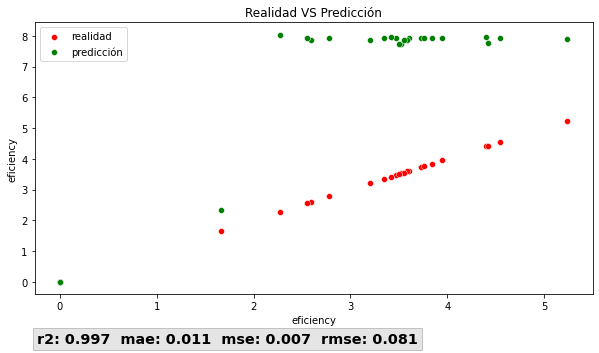

***************BaggingRegressor(base_estimator=Lasso(random_state=0))***************


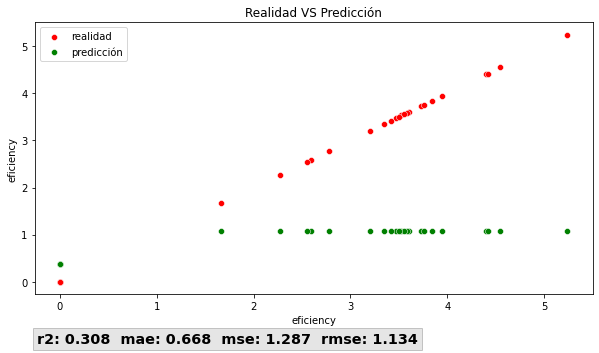

***************SVR(kernel='linear')***************


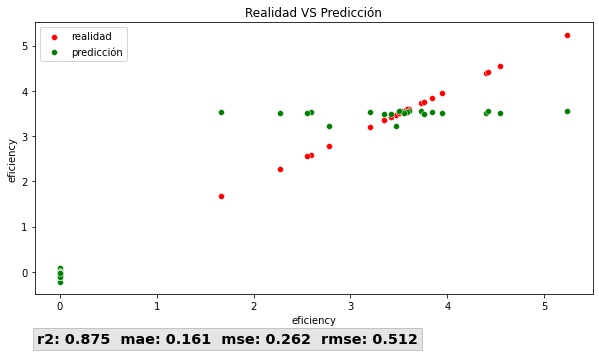

***************GradientBoostingRegressor(random_state=0)***************


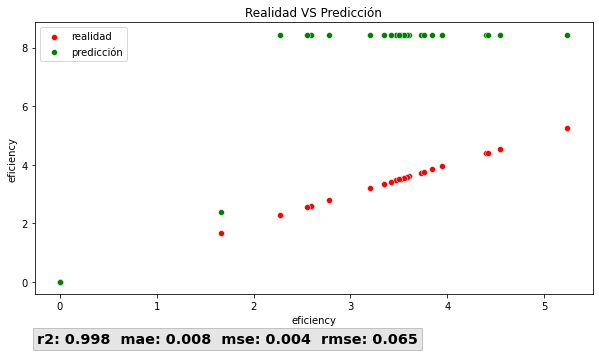

***************BaggingRegressor(base_estimator=Ridge(random_state=0))***************


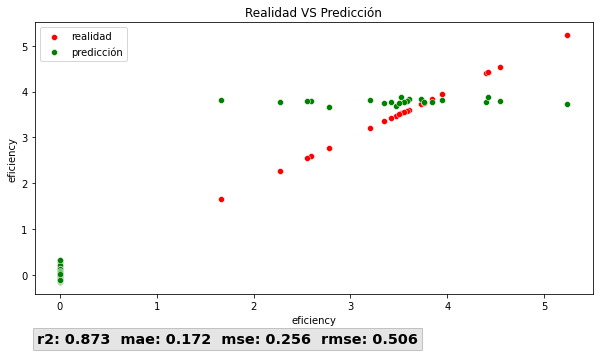

***************BaggingRegressor(base_estimator=ElasticNet(random_state=0))***************


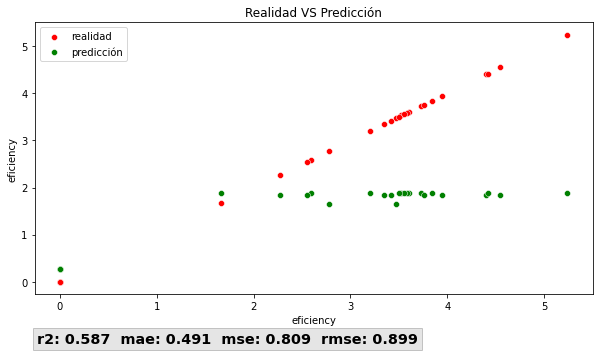

In [75]:
vif_vars = [x for x in df_cluster if x not in var_vif_3]
x_train,x_test,y_train,y_test = gp.data_transform(df_cluster,"eficiency",
                                                PowerTransformer(),
                                                skip_t=["energy_type"],
                                                skip_x=vif_vars)
for estimador in lista_estimadores:
    print(f"***************{str(estimador)}***************")
    Predicting.cross_val_regression(estimador,x_train,y_train,x_test,y_test)

### Modelo Cluster 3: variables mediante Rfecv

***************LinearRegression()***************


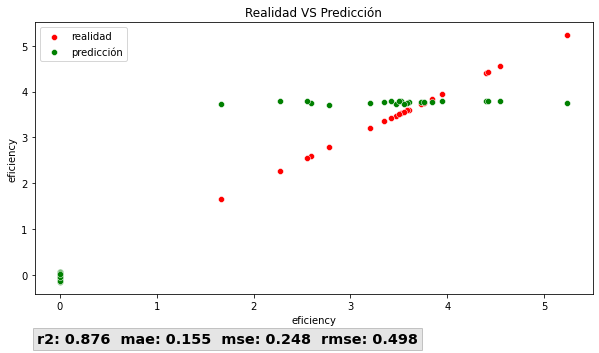

***************AdaBoostRegressor(base_estimator=DecisionTreeRegressor(random_state=0),
                  learning_rate=0.1, random_state=0)***************


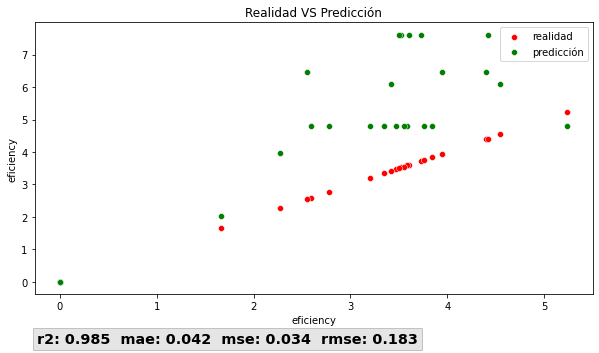

***************DecisionTreeRegressor(random_state=0)***************


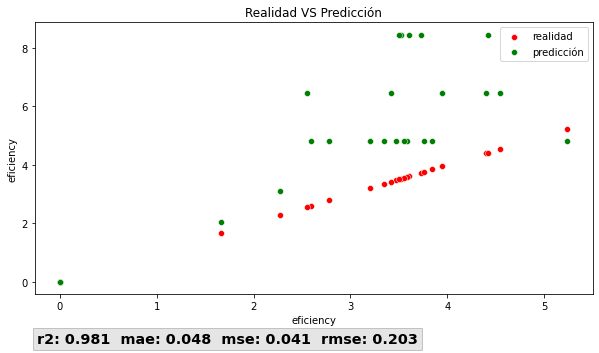

***************RandomForestRegressor(random_state=0)***************


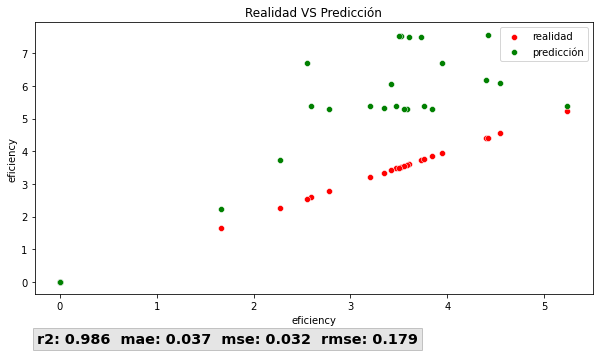

***************BaggingRegressor(base_estimator=Lasso(random_state=0))***************


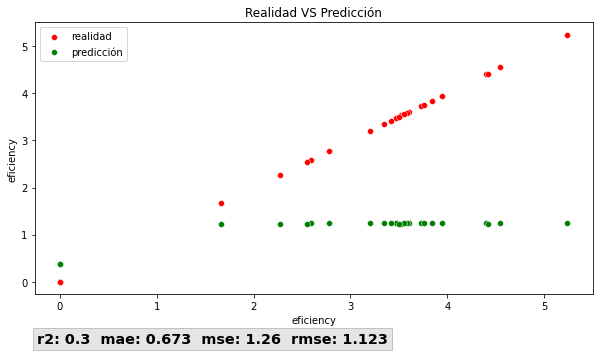

***************SVR(kernel='linear')***************


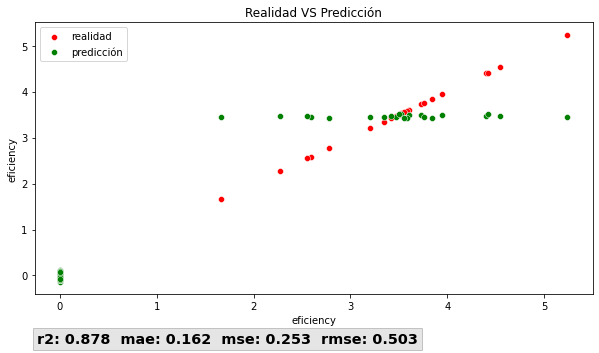

***************GradientBoostingRegressor(random_state=0)***************


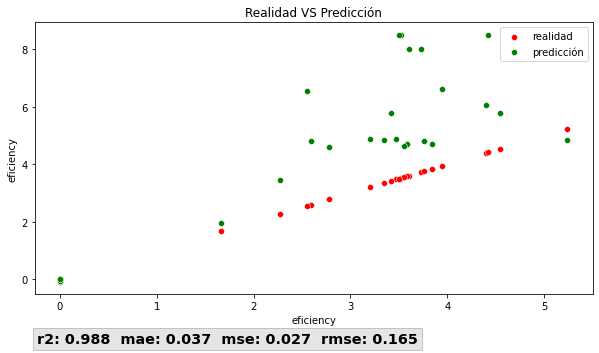

***************BaggingRegressor(base_estimator=Ridge(random_state=0))***************


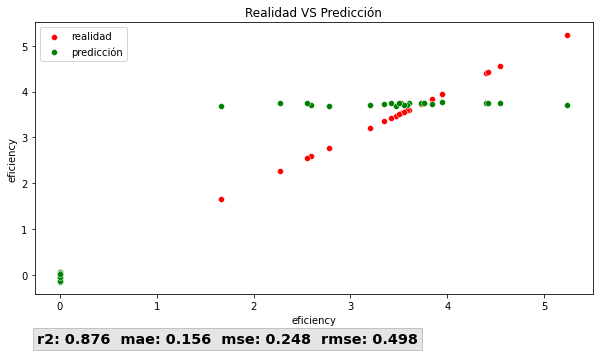

***************BaggingRegressor(base_estimator=ElasticNet(random_state=0))***************


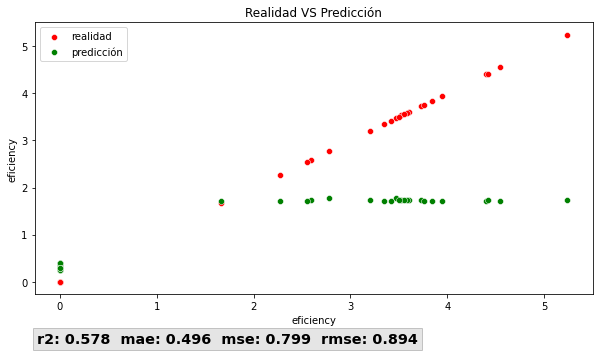

In [76]:
rfecv_vars = [x for x in df_cluster if x not in rfecv_vars_3]
x_train,x_test,y_train,y_test = gp.data_transform(df_cluster,"eficiency",
                                                PowerTransformer(),
                                                skip_t=["energy_type"],
                                                skip_x=rfecv_vars)
for estimador in lista_estimadores:
    print(f"***************{str(estimador)}***************")
    Predicting.cross_val_regression(estimador,x_train,y_train,x_test,y_test)

### Modelo Cluster 3: variables mediante OLS

***************LinearRegression()***************


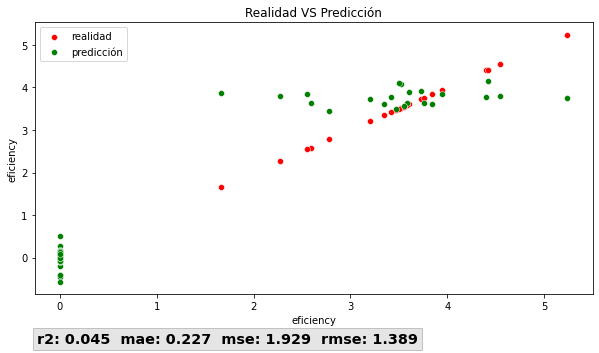

***************AdaBoostRegressor(base_estimator=DecisionTreeRegressor(random_state=0),
                  learning_rate=0.1, random_state=0)***************


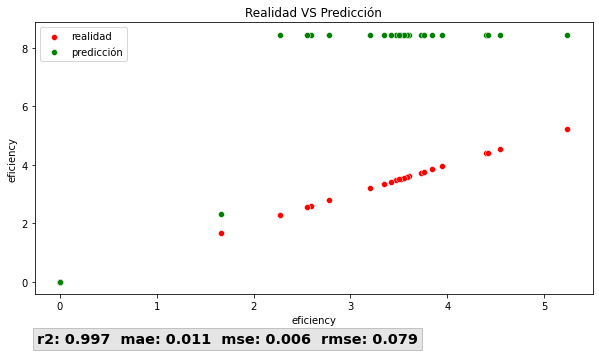

***************DecisionTreeRegressor(random_state=0)***************


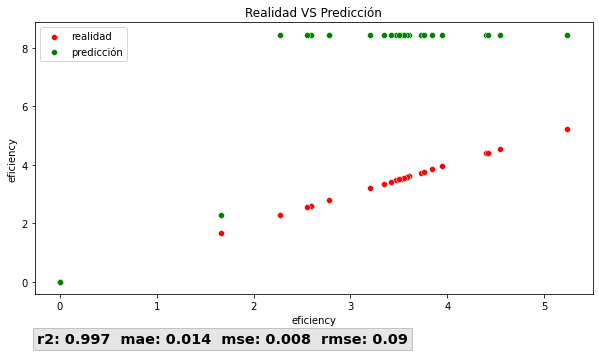

***************RandomForestRegressor(random_state=0)***************


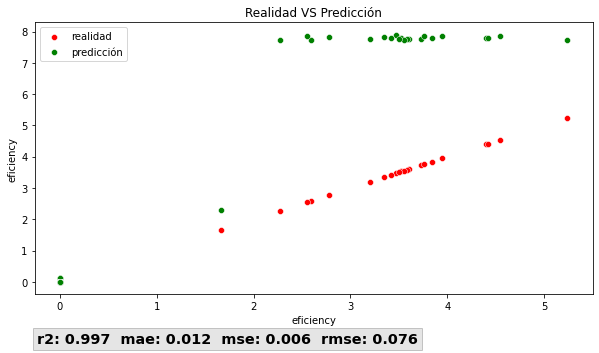

***************BaggingRegressor(base_estimator=Lasso(random_state=0))***************


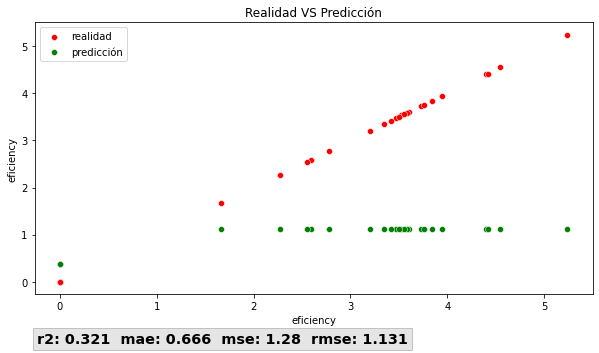

***************SVR(kernel='linear')***************


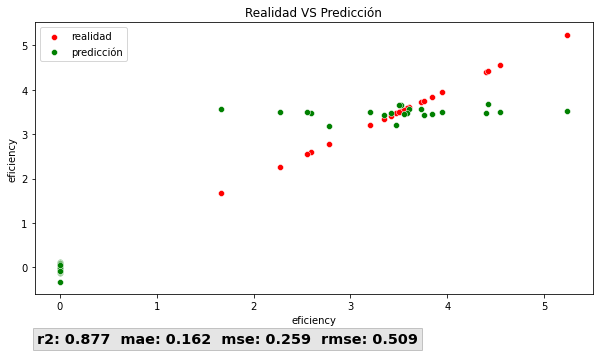

***************GradientBoostingRegressor(random_state=0)***************


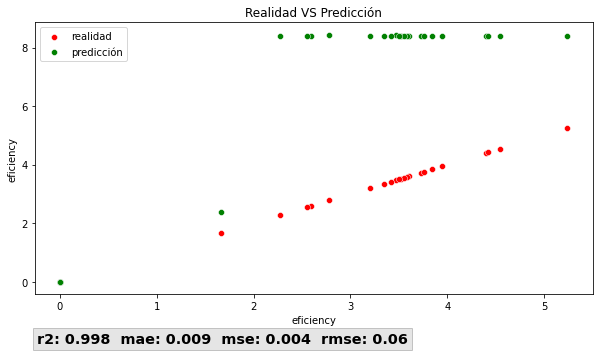

***************BaggingRegressor(base_estimator=Ridge(random_state=0))***************


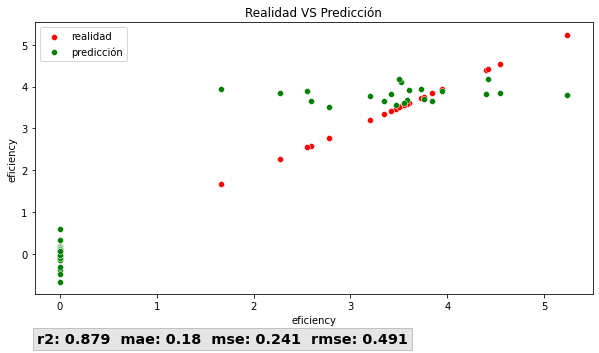

***************BaggingRegressor(base_estimator=ElasticNet(random_state=0))***************


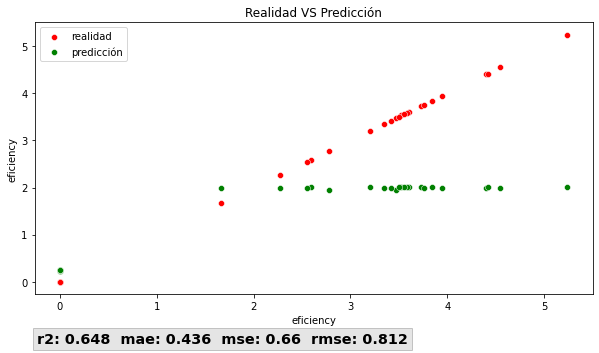

In [77]:
ols_vars_quitar = ["use_intensity_pc","energy_dependecy"]
x_train,x_test,y_train,y_test = gp.data_transform(df_cluster,"eficiency",
                                                PowerTransformer(),
                                                skip_t=["energy_type"],
                                                skip_x=ols_vars_quitar)
for estimador in lista_estimadores:
    print(f"***************{str(estimador)}***************")
    Predicting.cross_val_regression(estimador,x_train,y_train,x_test,y_test)

Teniendo en cuenta los mejores estimadores para cada método de selección de variables:

|estimador|R2|Mae|Rmse|n_variables|
|---------|--|---|----|-----------|
|GradientBoostingRegressor-Correlación|0.986|0.041|0.173|5|
|RandomForest-Vif|0.997|0.011|0.081|9|
|<mark>GradientBoostingRegressor-Rfecv</mark>|0.988|0.037|0.165|4|
|GradientBoostingRegressor-OLS|0.998|0.009|0.06|12|

hemos elegido:
$$\text{GradientBoostingRegressor con las variables de RFECV}$$

por los buenos datos, pues con menos variables lo hace mejor que el resto.


In [78]:
rfecv_vars = [x for x in df_cluster if x not in rfecv_vars_3]

x_train,x_test,y_train,y_test = gp.data_transform(df_cluster,"eficiency",
                                                PowerTransformer(),
                                                skip_t=["energy_type"],
                                                skip_x=rfecv_vars)

# Guardamos el modelo para el cluster 1:
reg_cluster3 = GradientBoostingRegressor(random_state=0)
reg_cluster3fit = reg_cluster3.fit(x_train,y_train)
gp.models_saver(reg_cluster3fit,"reg_cluster3")

Modelo guardado correctamente


# RESUMEN:

Primeramente hemos dividido el dataframe en clusters y hemos buscado las variables con las que podríamos tener mejores resultados para la predicción mediante 4 métodos:

1. correlación (hemos usado la de spearman debido a que es menos sensible a los valores extremos)
2. vif (Variation inflation factor, que nos dice la multicolinealidad existente en un modelo de multiples variables)
3. RFECV (Recursive Feature Elimination Cross Validation)
4. Ols (mirando la significancia estadística de las variables proporcionada por el regresor, además de aic y bic)

Luego hemos creado un base line general mirando r2,mae y rmse para determinar cual de los estimadores podría ser el mejor para nuestro modelo, usando todas las variables de las que disponemos. Una vez obtenido el baseline hemos intentado mejorarlo probando los diferentes algoritmos con las variables seleccionadas por cada uno de los métodos y los hemos comparado entre ellos, eligiendo el mejor modelo y las mejores variables de entre todos ellos teniendo en cuenta las mismas tres métricas que en el base line. De esta manera las variables y los estimadores elegidos para cada uno de los clusters han sido:

|CLUSTER|ESTIMADOR|VARIABLES|M.ELECCIÓN|
|-------|---------|---------|---------------|
|cluster 0|AdaBoostRegressor(DecisionTree)|['balance', 'Energy_consumption', 'Energy_production', 'CO2_emission']|RFECV y Correlación|
|cluster 1|DecisionTree|['CO2_emission', 'co2_pc', 'per_capita_production', 'Energy_consumption']|RFECV|
|cluster 2|RandomForest|['GDP', 'Population', 'Energy_consumption', 'CO2_emission', 'balance']|Correlación|
|cluster 3|GradientBoostingRegressor|['CO2_emission', 'Energy_production', 'balance', 'Energy_consumption']|RFECV|

Como recordamos al principio nuestro cluster 0 se caracterizaba por contener países que tienen poca producción pero emiten bastantes emisiones de co2, resultando poco eficientes y los menos eficientes de todos. Si relacionamos esta descripción con las variables que caracterizan su modelo podemos ver que tenemos:

+ balance
+ energy_consumption
+ energy_production
+ co2_emission

es decir, las variables que más caracterizan a esta descripción. Al ser países con poca producción y mucha emisión de co2, sabiendo la producción y el co2 podemos saber si cumplen esta cualidad. Además, al ser países que producen poco, son países con un consumo de energía superior a la producción y por tanto con un balance negativo.

Por otra parte, el cluster 1 está representado por países con poca produccción y pocas emisiones de co2 basados en el petróleo, las renovables y el gas natural, siendo los segundos menos eficientes de todos. Las variables que más los caracterizan para predecir su eficiencia han sido:

+ co2_emission
+ co2_pc
+ per_capita_production
+ Energy_consumption

En estos países, pensamos que el modelo ha preferido las variables per capita de las emisiones de co2 y de la producción porque contiene valores más pequeños, dados los valores también pequeños de las emisiones de co2 y la producción en valores absolutos. Aún así, como son países que los caracterizan mucho la pocas emisiones de co2 y el poco consumo de energía, en valores absolutos, el modelo los ha seleccionado como predictores de la eficiencia.

El cluster 2 tiene a los países con mayor producción y mayor emisión de co2 del mundo, muy por encima de los otros cluster, pero siendo los segundos más eficientes de los clusters. Su producción está basada en el carbón, el gas natural y el petróleo. Dada esta descripción, las variables que han caracterizado el modelo de regresión de la eficiencia han sido:

+ GDP
+ Population
+ Energy_consumption
+ CO2_emission
+ balance

Al ser países tan grandes en media y con tanta producción, son países con grandes productos interiores brutos y población. Además, son países que tienen un consumo elevado de energía debido a sus altos niveles de PIB y las emisiones de co2 son las más elevadas, llevando a que tengan balances de energía positivos.

En el cluster 3 nos encontramos a países con las segundas mayores producciones de energía mundiales, que usan todas las fuentes de energía en proporciones similares en media, y sus emisiones de co2 son muy bajas, cercanas al cluster 1 para una producción mucho mayor. Estos países son los más eficientes con diferencia y serían la referencia a seguir. Los países que más se encuentran a lo largo de los años del estudio en este cluster han sido:

1. Rusia
2. Estados Unidos
3. Canadá
4. Francia
5. Japón

Francia y Japón son dos países altamente enfocados en la energía nuclear(75,5% y 54,1% de su producción) y Estados Unidos la usa también, aunque en menor medida que estos dos países.Por otra parte Rusia junto con Canadá usan como fuentes prioritarias de producción el gas natural y el petróleo y en menor medida el carbón. Este medio de generación es el tercero para Rusia y el cuarto para Canadá que prioriza las renovables con un 21% de su producción total siendo la nuclear residual para ellos.
Como variables para predecir la eficiencia de este cluster han sido seleccionadas:
+ co2_emission
+ energy_production
+ balance
+ energy_consumption

que son variables muy parecidas a la de los clusters anteriores e iguales a las del cluster 0.  
Para concluir podemos decir que la eficiencia es posible predecirla en todos los clusters de manera general con una estructura de variables estable, y por tanto estas variables son las que más definen a la eficiencia. En este caso serían, la emisión de co2, la producción de energía,el consumo de energía y el balance entre la producción y el consumo de la misma.
